# Customer Segmentation Project: Online Retail Dataset

**Introduction**

This project analyzes customer purchasing behavior for a UK-based online gift retailer using the UCI Online Retail Dataset. By applying clustering techniques, we aim to segment customers into actionable groups to inform targeted marketing, personalized recommendations, and customer service improvements.

- **Dataset**: UCI Online Retail Dataset (541,909 transactions, 4,337 customers, 01/12/2010–09/12/2011)
- **Objectives**:
  - Perform exploratory data analysis (EDA) to identify purchasing patterns
  - Develop and apply clustering algorithms (K-Means, Hierarchical, DBSCAN) to segment customers
  - Derive RFM (Recency, Frequency, Monetary) and additional features (e.g., ProductDiversity)
  - Provide actionable business recommendations for marketing and customer retention
- **Approach**:
  - Preprocess data (handle missing values, remove outliers, calculate RFM)
  - Conduct EDA (sales trends, day-of-week patterns)
  - Cluster customers using K-Means with optimized cluster count
  - Evaluate segments using Silhouette Score and visualize with PCA
  - Generate segment-specific strategies (e.g., VIP programs, re-engagement campaigns)

- **Outcome**: Actionable customer segments (e.g., Champions, Lost Customers) with tailored recommendations

## Import dependencies

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import datetime as dt
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import warnings
warnings.filterwarnings('ignore')


## Set visualization styles for better plots

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

## Load dataset and see basic info

In [3]:
# Load the dataset
df = pd.read_excel('/content/Online Retail.xlsx')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nNumber of unique invoices: {df['InvoiceNo'].nunique()}")
print(f"Number of unique customers: {df['CustomerID'].nunique()}")
print(f"Number of unique products: {df['StockCode'].nunique()}")
print(f"Time period: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

# Display the first few rows
df.head()

Dataset shape: (541909, 8)

Number of unique invoices: 25900
Number of unique customers: 4372
Number of unique products: 4070
Time period: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data pre-processing

In [4]:
# Check data types and missing values
print("Data types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print(f"\nPercentage of rows with missing CustomerID: {df['CustomerID'].isnull().mean()*100:.2f}%")


Data types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Percentage of rows with missing CustomerID: 24.93%


In [5]:
def preprocess_data(df):
    """Preprocess the retail transaction dataset"""
    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()

    # Ensure date range is correct (01/12/2010 to 09/12/2011)
    start_date = pd.to_datetime('2010-12-01')
    end_date = pd.to_datetime('2011-12-09')
    df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
    df_cleaned = df_cleaned[(df_cleaned['InvoiceDate'] >= start_date) &
                           (df_cleaned['InvoiceDate'] <= end_date)]

    # Remove rows with missing CustomerID (required for customer segmentation)
    df_cleaned = df_cleaned.dropna(subset=['CustomerID'])

    # Convert CustomerID to integer
    df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

    # Remove canceled orders (indicated by negative quantity)
    df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]

    # Remove orders with invalid UnitPrice
    df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]

    # Calculate total price for each transaction
    df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

    # Extract date features
    df_cleaned['InvoiceDay'] = df_cleaned['InvoiceDate'].dt.day
    df_cleaned['InvoiceMonth'] = df_cleaned['InvoiceDate'].dt.month
    df_cleaned['InvoiceYear'] = df_cleaned['InvoiceDate'].dt.year
    df_cleaned['InvoiceDayOfWeek'] = df_cleaned['InvoiceDate'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_cleaned['InvoiceQuarter'] = df_cleaned['InvoiceDate'].dt.quarter

    # Create a flag for whether the purchase was made on a weekend
    df_cleaned['Weekend'] = df_cleaned['InvoiceDayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    return df_cleaned

# Apply preprocessing
df_cleaned = preprocess_data(df)
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceMonth,InvoiceYear,InvoiceDayOfWeek,InvoiceQuarter,Weekend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,12,2010,2,4,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,12,2010,2,4,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1,12,2010,2,4,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,12,2010,2,4,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,12,2010,2,4,0


## Comparision of original and cleaned data

In [6]:
# Compare original and cleaned data
print(f"Original data shape: {df.shape}")
print(f"Cleaned data shape: {df_cleaned.shape}")
print(f"Data retention rate: {df_cleaned.shape[0]/df.shape[0]:.2%}")

# Check the cleaned data
print("Summary statistics of cleaned data:")
df_cleaned.describe()

Original data shape: (541909, 8)
Cleaned data shape: (397267, 15)
Data retention rate: 73.31%
Summary statistics of cleaned data:


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice,InvoiceDay,InvoiceMonth,InvoiceYear,InvoiceDayOfWeek,InvoiceQuarter,Weekend
count,397267.000000,397267,397267.000000,397267.000000,397267.000000,397267.000000,397267.000000,397267.000000,397267.000000,397267.000000,397267.000000
mean,12.780397,2011-07-10 18:02:38.575819264,3.117460,15295.505267,21.967741,15.051570,7.605661,2010.934158,2.612394,2.854305,0.158012
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000,1.000000,1.000000,2010.000000,0.000000,1.000000,0.000000
25%,2.000000,2011-04-07 09:54:00,1.250000,13969.000000,4.680000,7.000000,5.000000,2011.000000,1.000000,2.000000,0.000000
50%,6.000000,2011-07-31 12:34:00,1.950000,15159.000000,11.800000,15.000000,8.000000,2011.000000,2.000000,3.000000,0.000000
75%,12.000000,2011-10-20 13:07:00,3.750000,16796.000000,19.800000,22.000000,11.000000,2011.000000,4.000000,4.000000,0.000000
max,74215.000000,2011-12-08 20:01:00,8142.750000,18287.000000,77183.600000,31.000000,12.000000,2011.000000,6.000000,4.000000,1.000000
std,125.303404,NaN,22.114772,1712.563251,155.711201,8.657185,3.414790,0.248007,1.929033,1.121838,0.364753


## Monthly sales trend

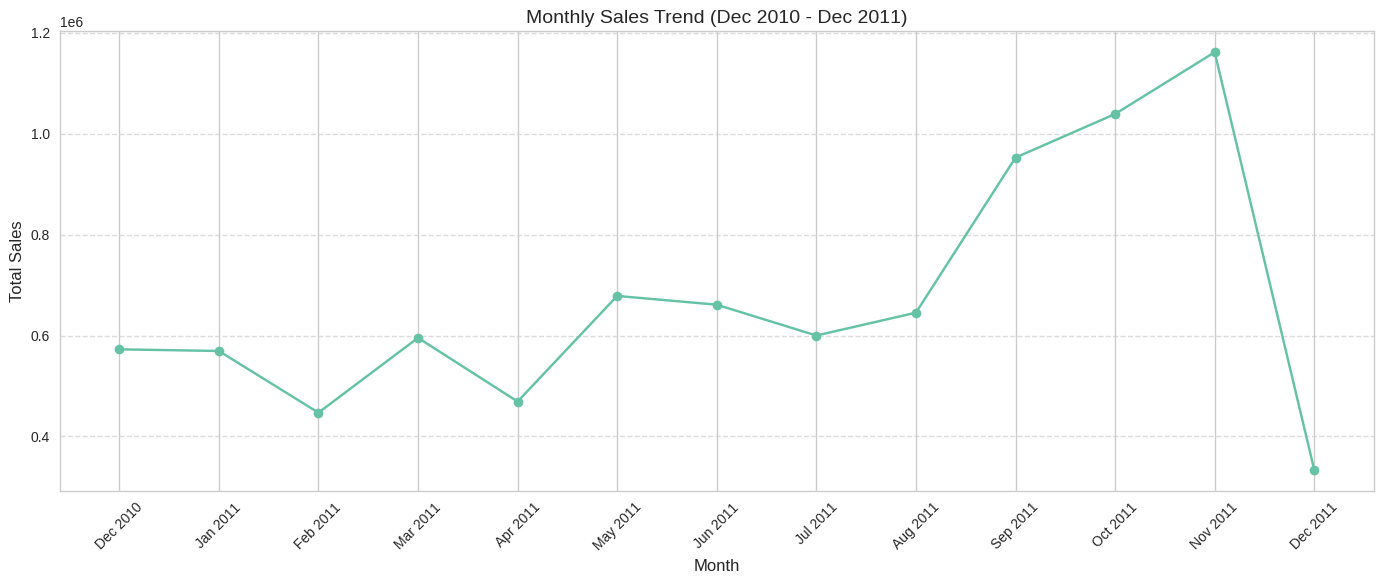

In [7]:
# Monthly sales trend
monthly_sales = df_cleaned.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['TotalPrice'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['InvoiceDate'].dt.strftime('%b %Y')

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['Month'], monthly_sales['TotalPrice'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend (Dec 2010 - Dec 2011)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Top 10 countries by sales

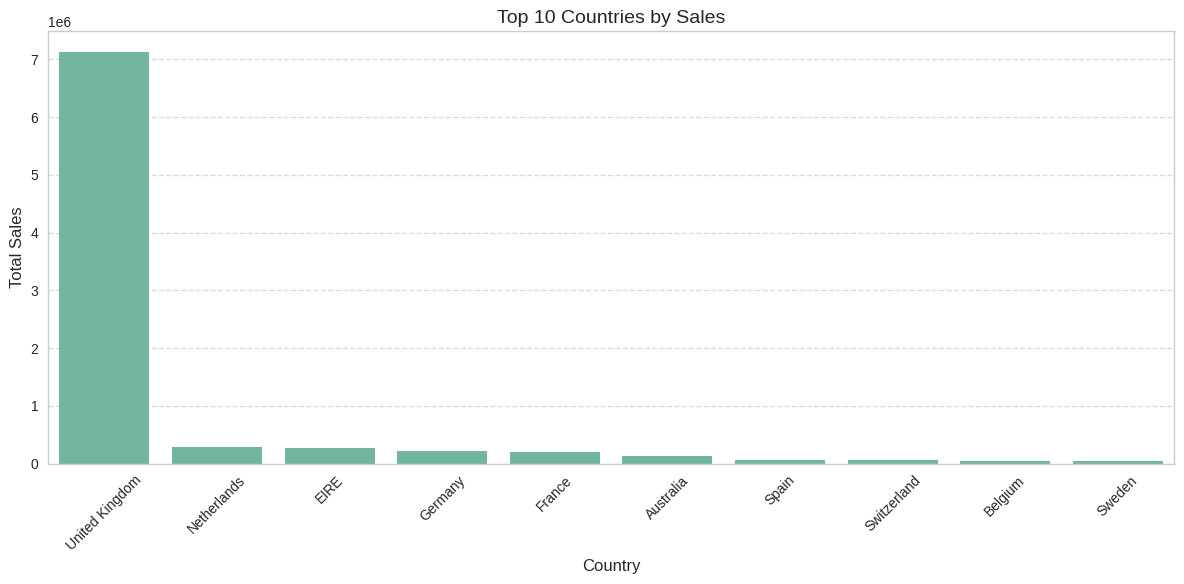

In [8]:
# Top 10 countries by sales
country_sales = df_cleaned.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_sales.index, y=country_sales.values)
plt.title('Top 10 Countries by Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of order values

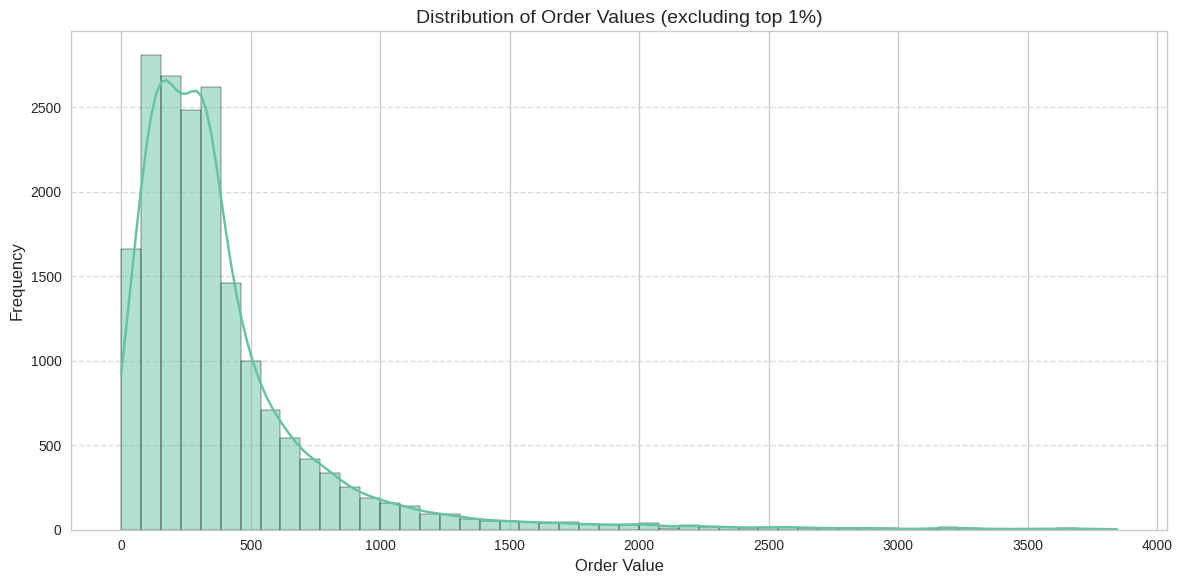

In [9]:
# Distribution of order values
order_values = df_cleaned.groupby('InvoiceNo')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
sns.histplot(order_values[order_values < order_values.quantile(0.99)], bins=50, kde=True)
plt.title('Distribution of Order Values (excluding top 1%)')
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Statistics about order values
print(f"Minimum order value: £{order_values.min():.2f}")
print(f"Maximum order value: £{order_values.max():.2f}")
print(f"Mean order value: £{order_values.mean():.2f}")
print(f"Median order value: £{order_values.median():.2f}")

Minimum order value: £0.38
Maximum order value: £77183.60
Mean order value: £471.96
Median order value: £303.04


## Sales by day of week

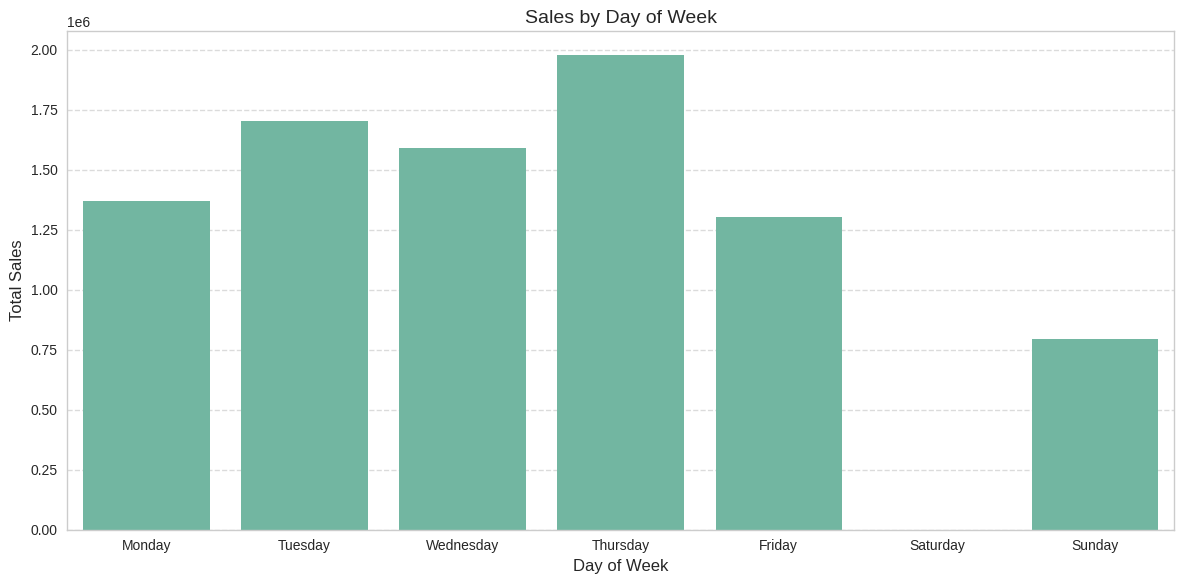

In [11]:
# Sales by day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_sales = df_cleaned.groupby('InvoiceDayOfWeek')['TotalPrice'].sum().reindex(range(7))

plt.figure(figsize=(12, 6))
sns.barplot(x=[day_names[i] for i in day_sales.index], y=day_sales.values)
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Create RFM Features

In [12]:
def create_rfm_features(df, end_date=None):
    """Create RFM (Recency, Frequency, Monetary) features for customer segmentation."""
    # If no end date is provided, use the most recent date in the dataset
    if end_date is None:
        end_date = df['InvoiceDate'].max()

    # Group by customer and calculate RFM metrics
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (end_date - x.max()).days,  # Recency: days since last purchase
        'InvoiceNo': 'nunique',                             # Frequency: number of purchases
        'TotalPrice': 'sum'                                 # Monetary: total spending
    })

    # Rename columns
    rfm.columns = ['Recency', 'Frequency', 'Monetary']

    return rfm

# Reference date for calculating recency (end of the dataset period)
ref_date = df_cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create RFM features
rfm_df = create_rfm_features(df_cleaned, ref_date)

# Display the RFM dataframe
print("RFM features:")
print(f"Number of customers: {len(rfm_df)}")
rfm_df.head()


RFM features:
Number of customers: 4337


,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


In [13]:
# Descriptive statistics of RFM features
rfm_df.describe()

,Recency,Frequency,Monetary
count,4337.000000,4337.000000,4337.000000
mean,92.288679,4.263546,2012.233946
std,99.903725,7.678770,8620.915492
min,1.000000,1.000000,2.900000
25%,17.000000,1.000000,307.090000
50%,50.000000,2.000000,673.100000
75%,142.000000,5.000000,1659.750000
max,373.000000,208.000000,280206.020000


## Additional features

In [14]:
def create_additional_features(df):
    """Create additional customer-level features beyond basic RFM."""
    # Transaction-level features per customer
    add_features = df.groupby('CustomerID').agg({
        'Quantity': ['sum', 'mean', 'std', 'min', 'max'],       # Order size statistics
        'UnitPrice': ['mean', 'std', 'min', 'max'],             # Price point statistics
        'TotalPrice': ['mean', 'std', 'min', 'max'],            # Order value statistics
        'InvoiceDayOfWeek': ['mean', 'std'],                    # Shopping day patterns
        'Weekend': 'mean',                                       # Weekend shopping preference
        'InvoiceNo': 'count'                                     # Number of items purchased
    })

    # Flatten the column hierarchy
    add_features.columns = ['_'.join(col).strip() for col in add_features.columns.values]

    # Calculate average items per transaction
    add_features['ItemsPerTransaction'] = add_features['Quantity_sum'] / add_features['InvoiceNo_count']

    # Calculate product diversity (unique products / total quantity)
    product_counts = df.groupby('CustomerID')['StockCode'].nunique().to_frame(name='UniqueProducts')
    add_features = pd.merge(add_features, product_counts, on='CustomerID', how='left')
    add_features['ProductDiversity'] = add_features['UniqueProducts'] / add_features['Quantity_sum']

    # Handle infinities and NaNs
    add_features = add_features.replace([np.inf, -np.inf], np.nan)
    add_features = add_features.fillna(0)

    return add_features

# Create additional features
additional_features = create_additional_features(df_cleaned)

# Merge with RFM features
customer_features = pd.merge(rfm_df, additional_features, on='CustomerID', how='left')
customer_features = customer_features.fillna(0)

# Display the extended feature set
print(f"Extended feature set: {customer_features.shape[1]} features for {customer_features.shape[0]} customers")
customer_features.head()

Extended feature set: 23 features for 4337 customers


,Recency,Frequency,Monetary,Quantity_sum,Quantity_mean,Quantity_std,Quantity_min,Quantity_max,UnitPrice_mean,UnitPrice_std,...,TotalPrice_std,TotalPrice_min,TotalPrice_max,InvoiceDayOfWeek_mean,InvoiceDayOfWeek_std,Weekend_mean,InvoiceNo_count,ItemsPerTransaction,UniqueProducts,ProductDiversity
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,325,1,77183.60,74215,74215.000000,0.000000,74215,74215,1.040000,0.000000,...,0.000000,77183.60,77183.6,1.000000,0.000000,0.000000,1,74215.000000,1,0.000013
12347,2,7,4310.00,2458,13.505495,18.856172,2,240,2.644011,2.255381,...,23.289902,5.04,249.6,1.423077,1.108538,0.000000,182,13.505495,103,0.041904
12348,75,4,1797.24,2341,75.516129,51.091990,1,144,5.764839,13.400323,...,48.514857,13.20,240.0,2.580645,1.478156,0.096774,31,75.516129,22,0.009398
12349,18,1,1757.55,631,8.643836,6.982856,1,36,8.289041,35.028021,...,34.655913,6.64,300.0,0.000000,0.000000,0.000000,73,8.643836,73,0.115689
12350,310,1,334.40,197,11.588235,4.345383,1,24,3.841176,9.334751,...,7.275538,8.50,40.0,2.000000,0.000000,0.000000,17,11.588235,17,0.086294


## Visualize RFM distributions

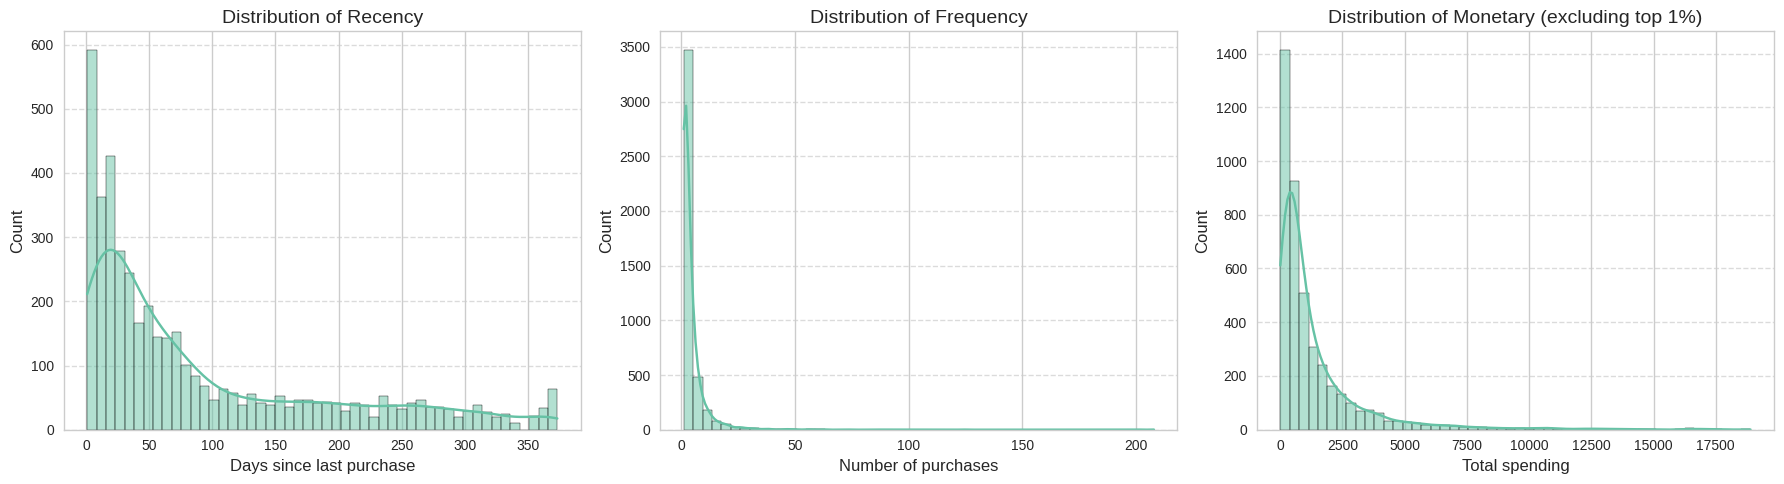

In [15]:
# Visualize RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency distribution
sns.histplot(customer_features['Recency'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Recency')
axes[0].set_xlabel('Days since last purchase')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Frequency distribution
sns.histplot(customer_features['Frequency'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Frequency')
axes[1].set_xlabel('Number of purchases')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Monetary distribution (excluding outliers)
monetary_data = customer_features['Monetary'][customer_features['Monetary'] < customer_features['Monetary'].quantile(0.99)]
sns.histplot(monetary_data, bins=50, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Monetary (excluding top 1%)')
axes[2].set_xlabel('Total spending')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Visualize relationships between RFM variables

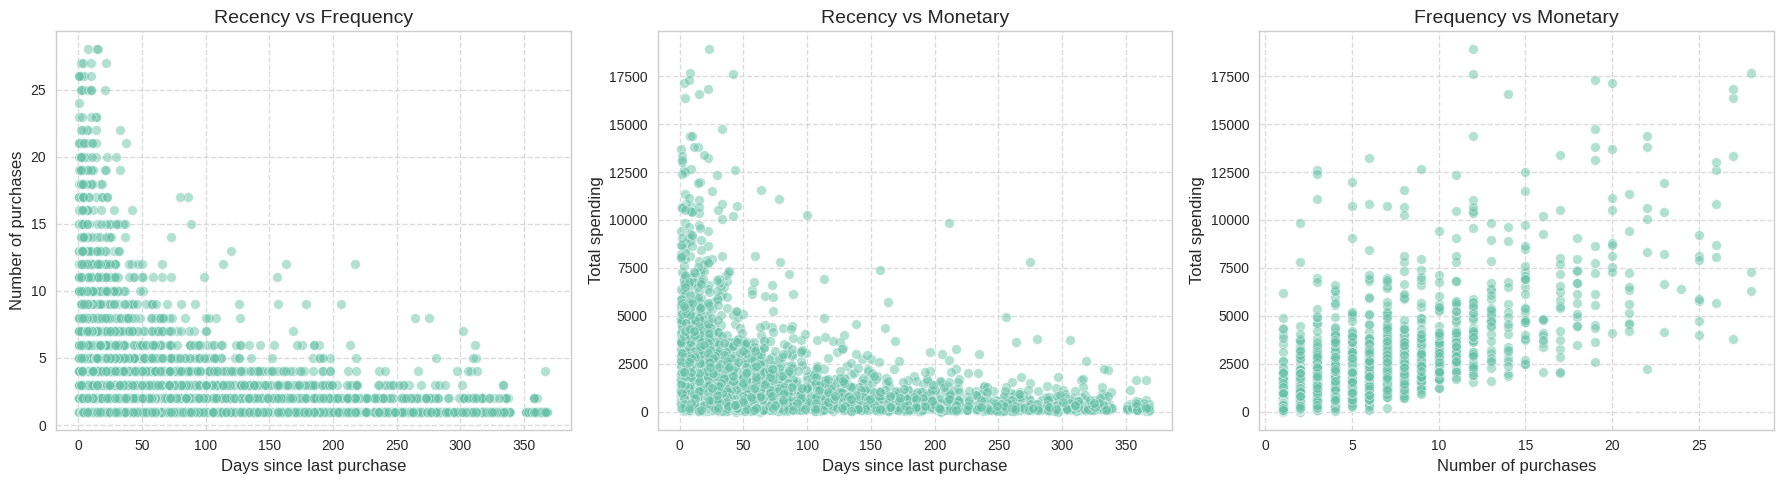

In [16]:
# Visualize relationships between RFM variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Filter out extreme values for better visualization
filtered_customers = customer_features[
    (customer_features['Recency'] < customer_features['Recency'].quantile(0.99)) &
    (customer_features['Frequency'] < customer_features['Frequency'].quantile(0.99)) &
    (customer_features['Monetary'] < customer_features['Monetary'].quantile(0.99))
]

# Recency vs Frequency
sns.scatterplot(x='Recency', y='Frequency', data=filtered_customers, alpha=0.5, ax=axes[0])
axes[0].set_title('Recency vs Frequency')
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Number of purchases')
axes[0].grid(linestyle='--', alpha=0.7)

# Recency vs Monetary
sns.scatterplot(x='Recency', y='Monetary', data=filtered_customers, alpha=0.5, ax=axes[1])
axes[1].set_title('Recency vs Monetary')
axes[1].set_xlabel('Days since last purchase')
axes[1].set_ylabel('Total spending')
axes[1].grid(linestyle='--', alpha=0.7)

# Frequency vs Monetary
sns.scatterplot(x='Frequency', y='Monetary', data=filtered_customers, alpha=0.5, ax=axes[2])
axes[2].set_title('Frequency vs Monetary')
axes[2].set_xlabel('Number of purchases')
axes[2].set_ylabel('Total spending')
axes[2].grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Correlation analysis

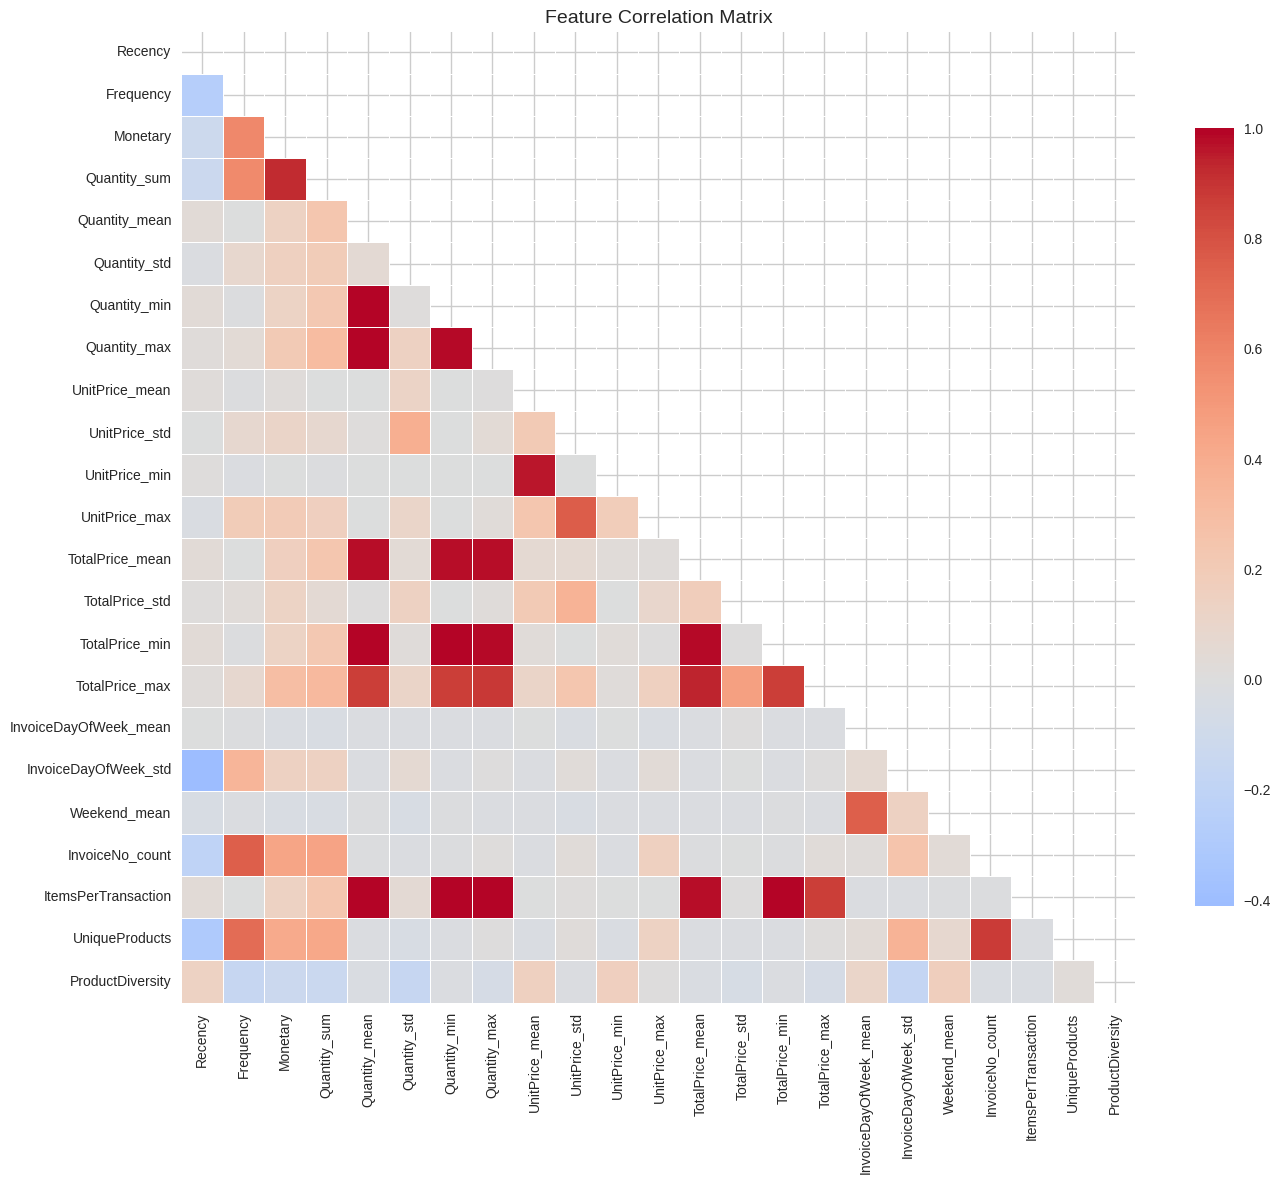

In [17]:
# Correlation analysis
plt.figure(figsize=(14, 12))
correlation_matrix = customer_features.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Data Preparation

In [18]:
def prepare_for_clustering(df):
    """Prepare customer features for clustering algorithms."""
    # Make a copy of the features
    clustering_df = df.copy()

    # Reset index to make CustomerID a column
    clustering_df = clustering_df.reset_index()

    # Select only the most relevant features for clustering
    selected_features = [
        'CustomerID',
        'Recency',                # How recently a customer made a purchase
        'Frequency',              # How often a customer makes purchases
        'Monetary',               # How much money a customer spends
        'TotalPrice_mean',        # Average order value
        'Quantity_mean',          # Average order size
        'ProductDiversity',       # Diversity of products purchased
        'Weekend_mean'            # Preference for weekend shopping
    ]

    clustering_df = clustering_df[selected_features]

    # Store CustomerID separately
    customer_ids = clustering_df['CustomerID']

    # Drop CustomerID for scaling
    X = clustering_df.drop('CustomerID', axis=1)
    feature_names = X.columns

    # Log-transform highly skewed features
    skewed_features = ['Recency', 'Frequency', 'Monetary', 'TotalPrice_mean']
    for feature in skewed_features:
        if feature in X.columns:
            X[feature] = np.log1p(X[feature])

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create a DataFrame with scaled values
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)
    X_scaled_df.index = customer_ids

    return X_scaled_df, feature_names, customer_ids

# Prepare data for clustering
X_scaled_df, feature_names, customer_ids = prepare_for_clustering(customer_features)

# Display the scaled features
print(f"Selected and scaled features: {X_scaled_df.shape[1]} features for {X_scaled_df.shape[0]} customers")
X_scaled_df.head()

Selected and scaled features: 7 features for 4337 customers


,Recency,Frequency,Monetary,TotalPrice_mean,Quantity_mean,ProductDiversity,Weekend_mean
CustomerID,,,,,,,
12346,1.457652,-0.954916,3.711436,9.737717,65.544920,-1.003698,-0.472777
12347,-2.023248,1.076956,1.415520,0.266124,-0.022392,-0.667425,-0.472777
12348,0.376497,0.388078,0.719700,1.291294,0.032403,-0.928367,-0.127105
12349,-0.652782,-0.954916,0.701939,0.284797,-0.026688,-0.075118,-0.472777
12350,1.422678,-0.954916,-0.616645,0.057419,-0.024086,-0.311084,-0.472777


## Principle Component Analysis

Explained variance by component: [0.35718495 0.21956762 0.14381742]
Total explained variance: 0.7206


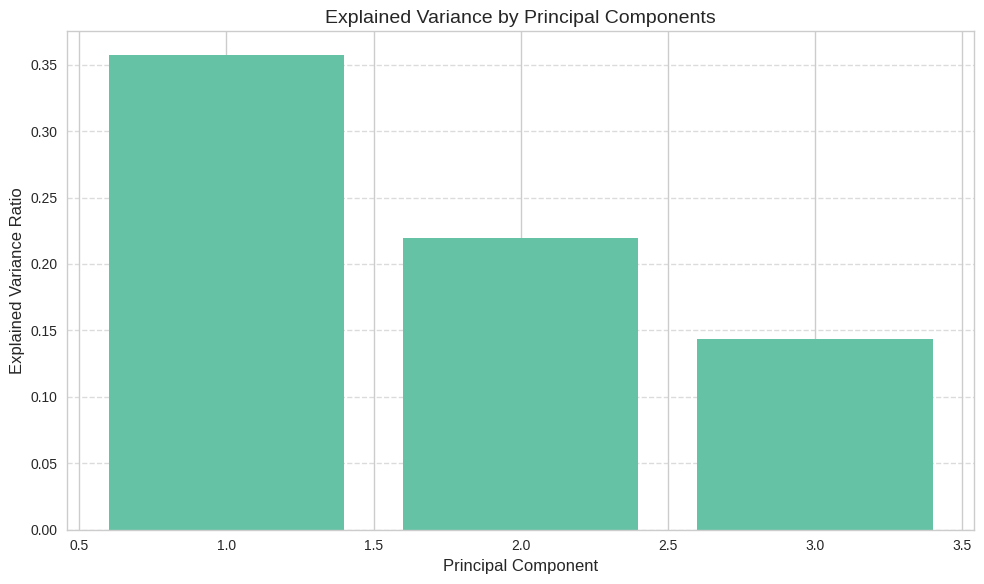

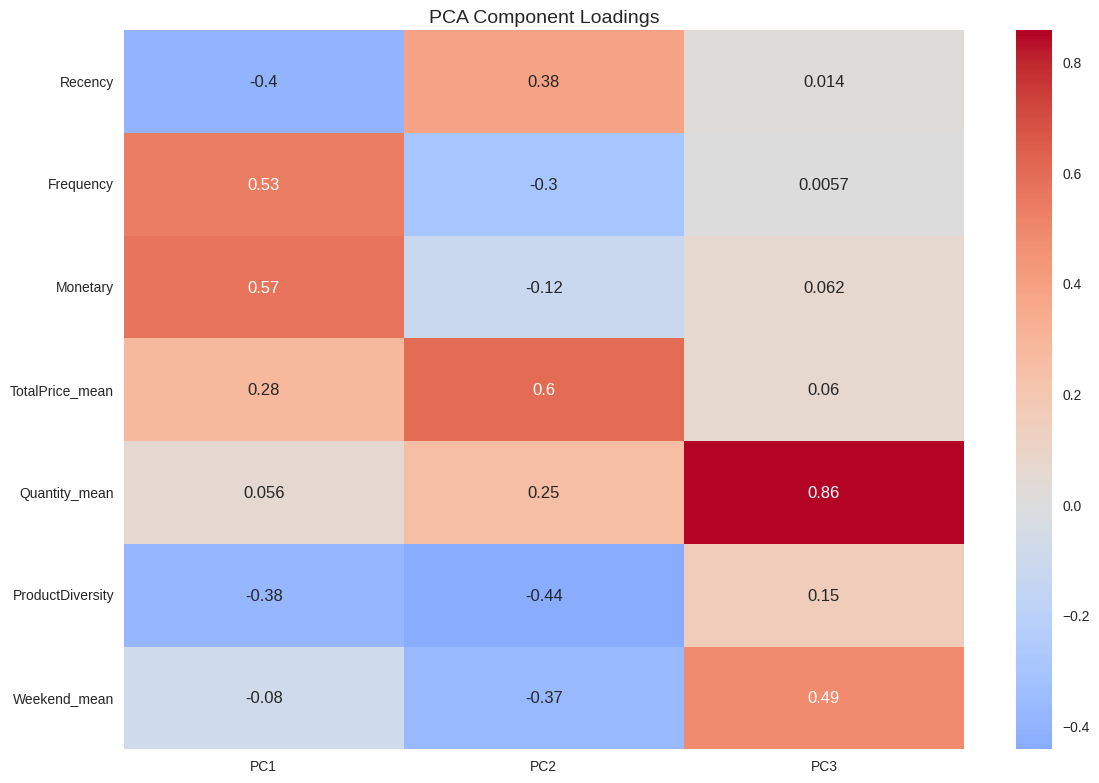

In [19]:
def apply_pca(X_scaled, feature_names, n_components=3):
    """Apply PCA for dimensionality reduction and visualization."""
    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    # Create DataFrame with principal components
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

    # Print explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component: {explained_variance}")
    print(f"Total explained variance: {sum(explained_variance):.4f}")

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components+1), explained_variance)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("\n\n")
    # Plot component loadings
    plt.figure(figsize=(12, 8))
    loadings = pca.components_.T

    # Create a heatmap of the loadings
    loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(n_components)], index=feature_names)
    sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
    plt.title('PCA Component Loadings')
    plt.tight_layout()
    plt.show()

    return pca_df, pca

# Apply PCA
pca_df, pca_model = apply_pca(X_scaled_df.values, X_scaled_df.columns)

## K-Means Clustering

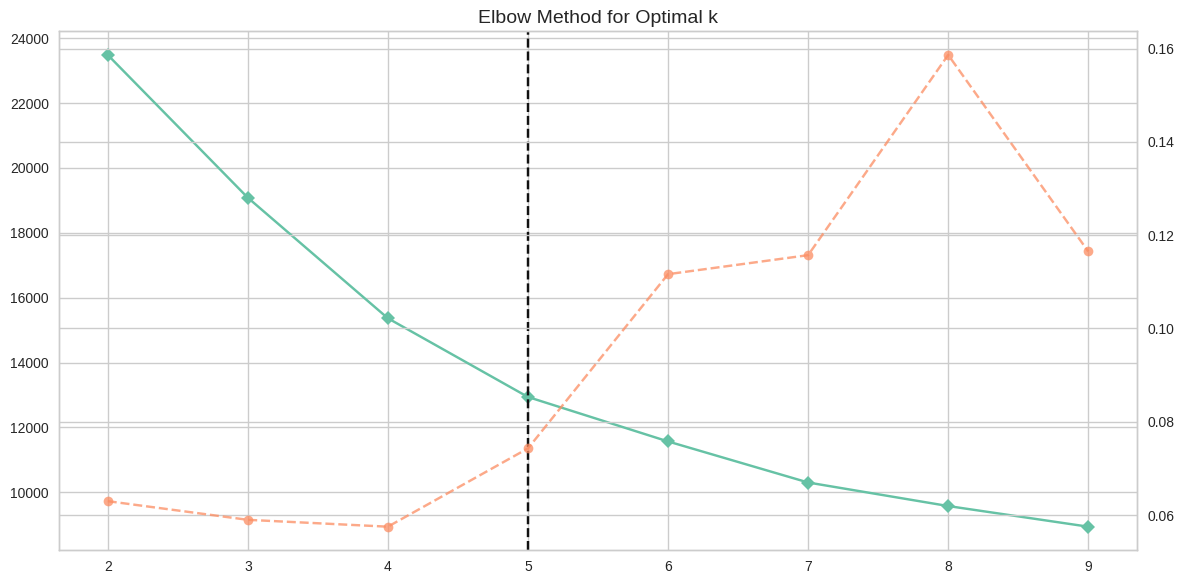

Optimal number of clusters for K-means: 5


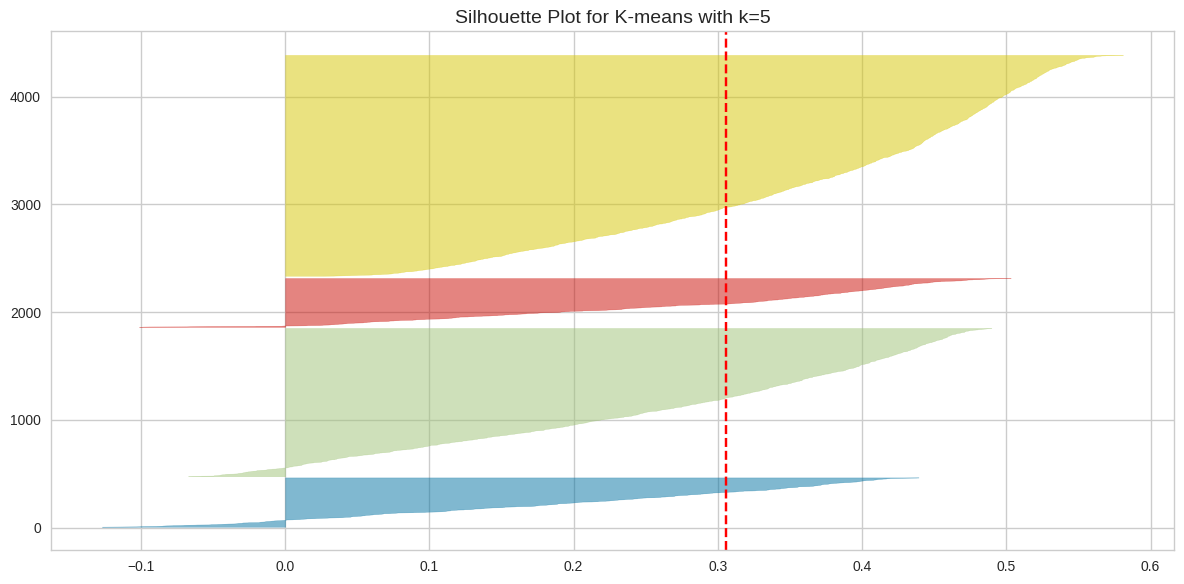

K-means Validation Metrics:
Silhouette Score: 0.3056
Calinski-Harabasz Index: 1458.3634


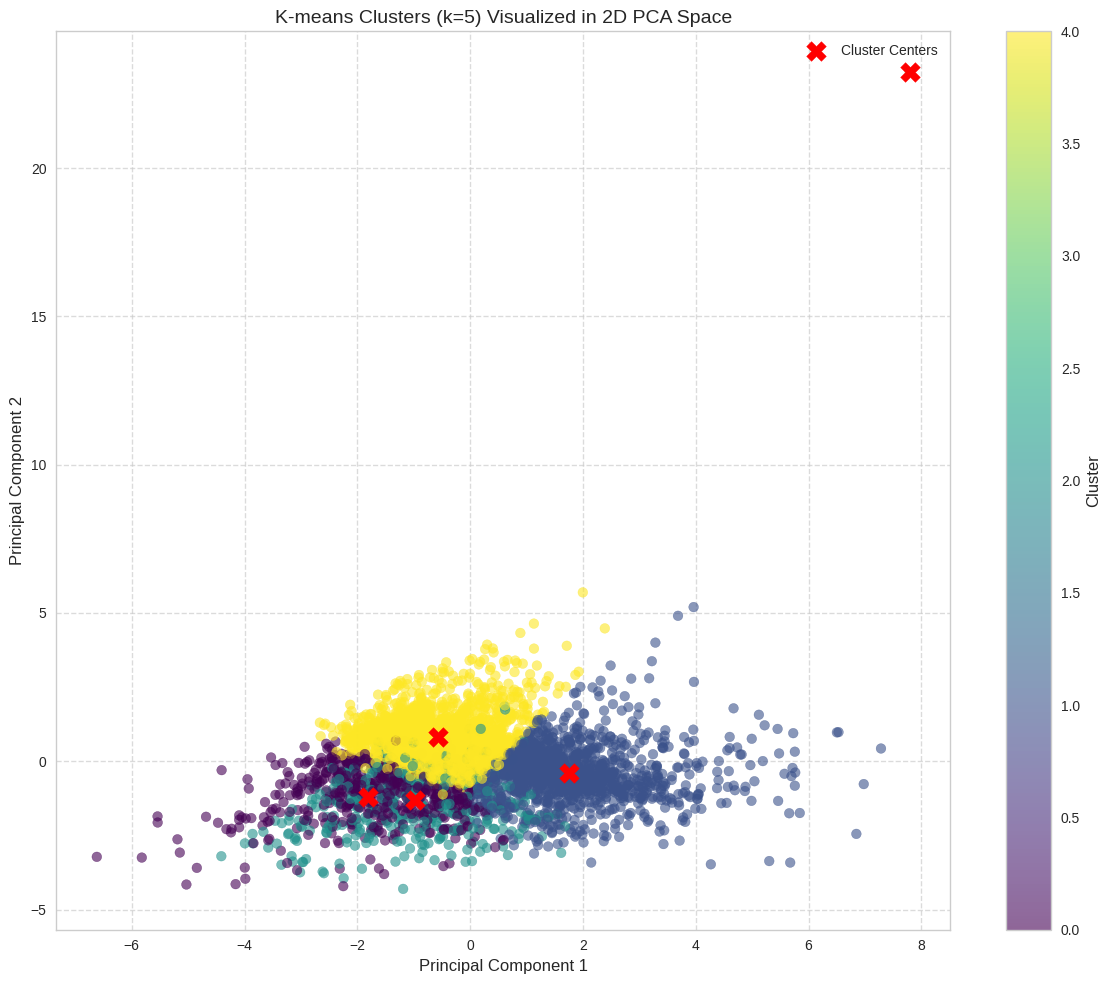

In [20]:
def apply_kmeans(X_scaled, max_clusters=10):
    """Apply K-means clustering and determine the optimal number of clusters."""
    # Find optimal number of clusters using the Elbow method
    plt.figure(figsize=(12, 6))
    visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=(2, max_clusters))
    visualizer.fit(X_scaled)
    plt.title('Elbow Method for Optimal k')
    plt.tight_layout()
    plt.show()
    optimal_k = visualizer.elbow_value_

    # If no clear elbow is found, use silhouette scores
    if optimal_k is None:
        print("No clear elbow found. Using silhouette scores to determine optimal clusters.")
        silhouette_scores = []
        for k in range(2, max_clusters+1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            silhouette_scores.append(score)

        plt.figure(figsize=(12, 6))
        plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Scores for Different k Values')
        plt.grid(linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2

    print(f"Optimal number of clusters for K-means: {optimal_k}")

    # Apply K-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)

    # Visualize silhouette scores for the optimal k
    plt.figure(figsize=(12, 6))
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X_scaled)
    plt.title(f'Silhouette Plot for K-means with k={optimal_k}')
    plt.tight_layout()
    plt.show()

    # Calculate validation metrics
    silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
    calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)

    print(f"K-means Validation Metrics:")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

    return kmeans_labels, optimal_k, kmeans

# Apply K-means clustering
kmeans_labels, optimal_k, kmeans_model = apply_kmeans(X_scaled_df.values)

# Visualize K-means clusters in PCA space
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-means Clusters (k={optimal_k}) Visualized in 2D PCA Space')

# Add cluster centers
centers_pca = pca_model.transform(kmeans_model.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, marker='X', c='red', label='Cluster Centers')

plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Hierarchical Clustering

Using a sample of 1000 customers for dendrogram visualization


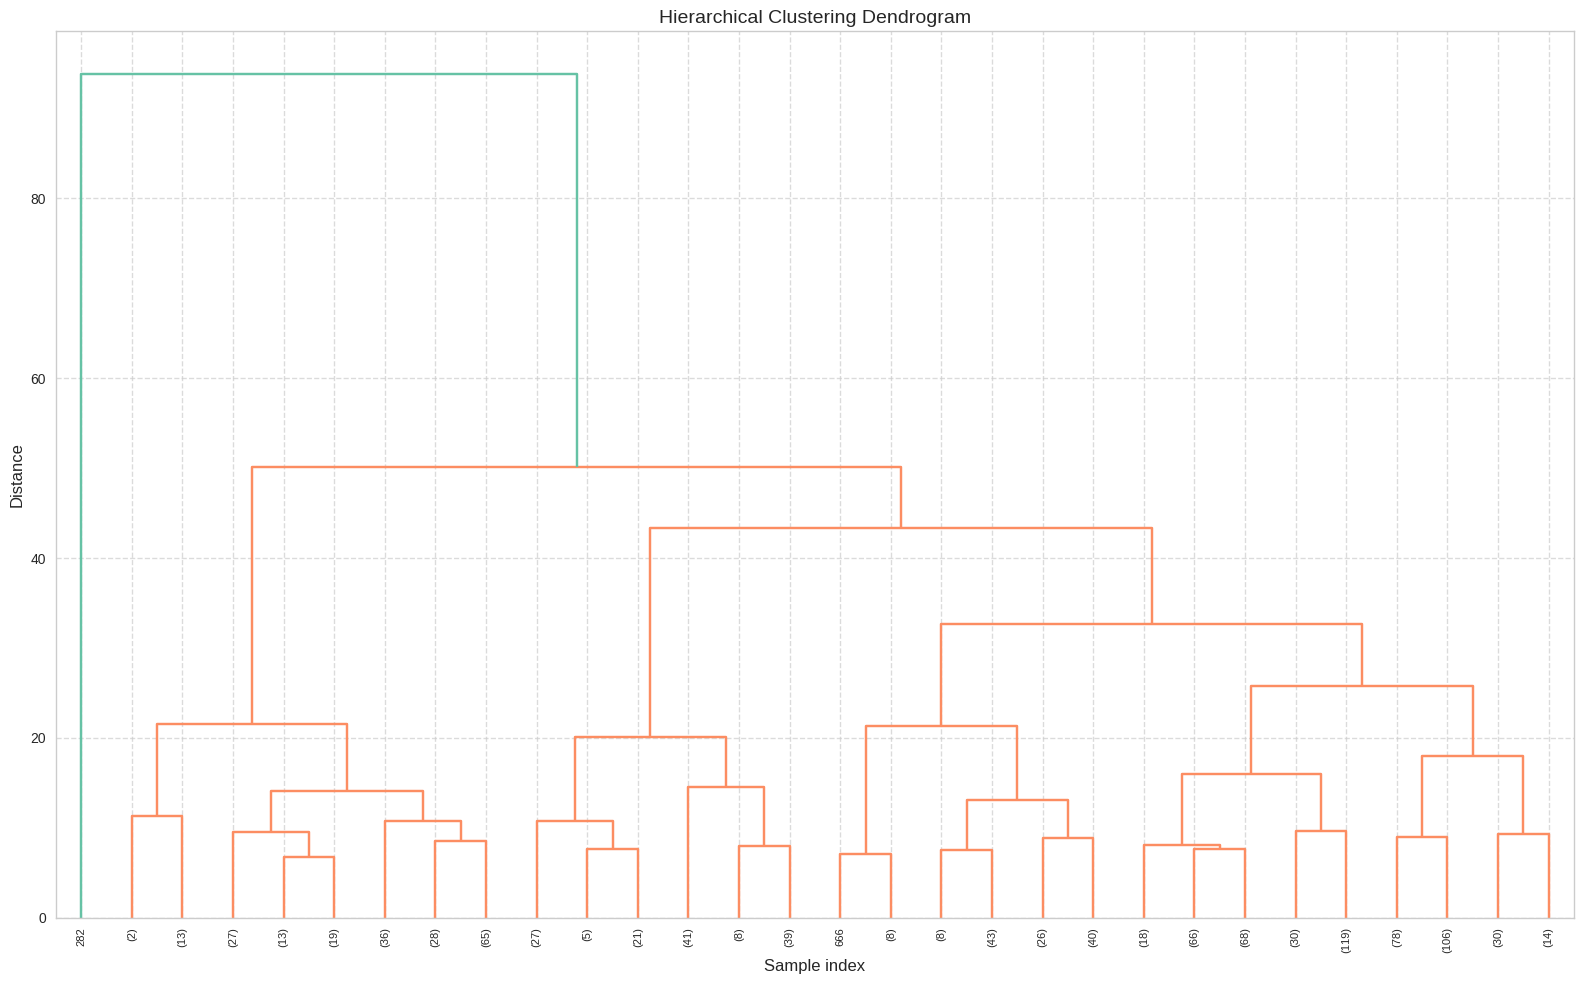

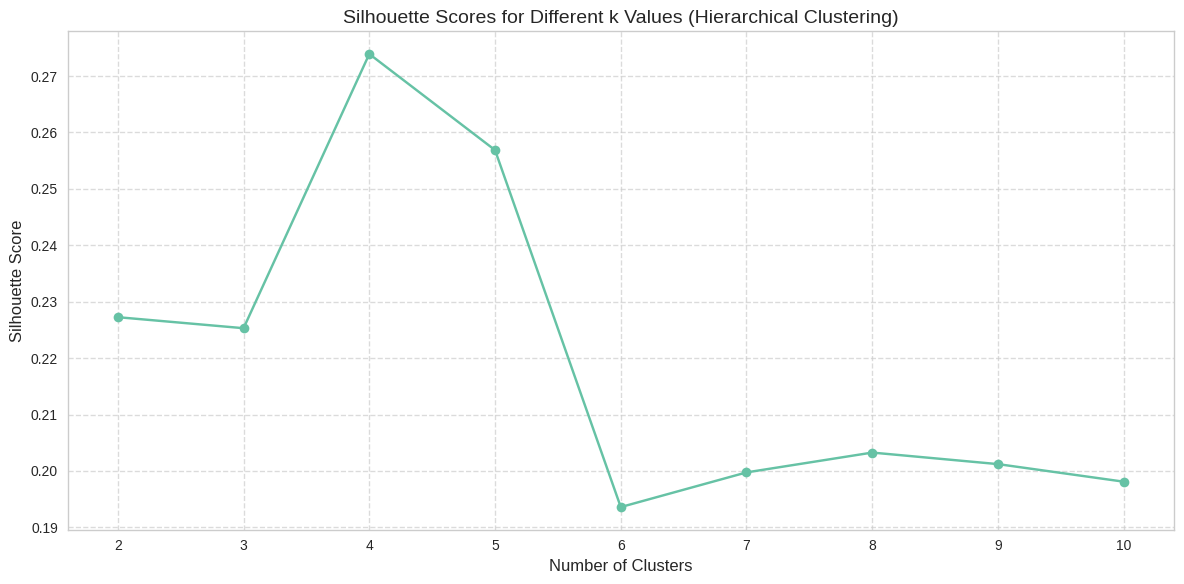

Optimal number of clusters for Hierarchical Clustering: 4
Hierarchical Clustering Validation Metrics:
Silhouette Score: 0.2739
Calinski-Harabasz Index: 1259.0148


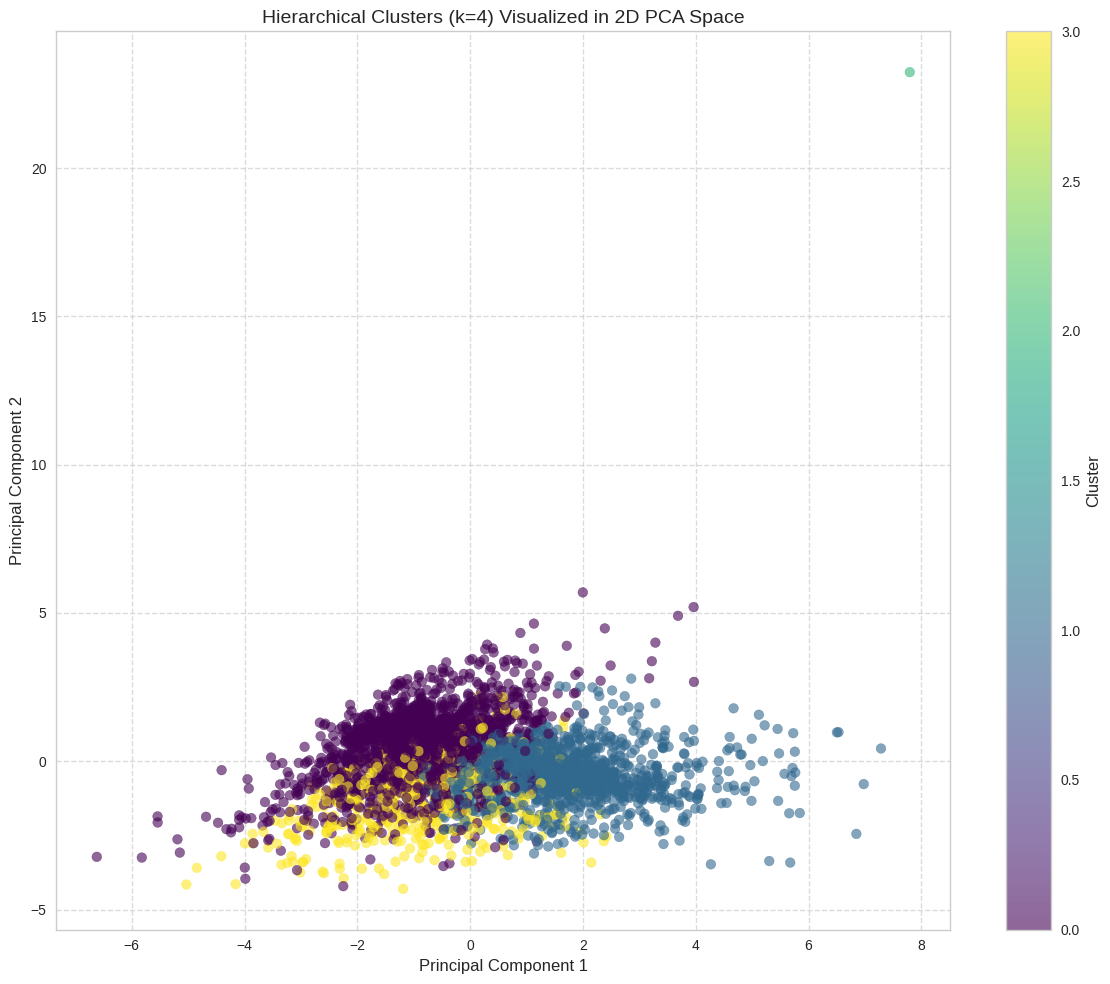

In [21]:
def apply_hierarchical_clustering(X_scaled, max_clusters=10):
    """Apply hierarchical clustering and determine the optimal number of clusters."""
    # Calculate linkage for a sample of data (for efficiency in dendrogram visualization)
    # For large datasets, we might need to sample
    if X_scaled.shape[0] > 1000:
        sample_indices = np.random.choice(X_scaled.shape[0], 1000, replace=False)
        X_sample = X_scaled[sample_indices]
        print("Using a sample of 1000 customers for dendrogram visualization")
    else:
        X_sample = X_scaled
        print(f"Using all {X_scaled.shape[0]} customers for dendrogram visualization")

    Z = linkage(X_sample, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(16, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # Show only the last p merged clusters
        p=30,                  # Show only the last 30 merged clusters
        leaf_rotation=90.,
        leaf_font_size=8.
    )
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Find optimal number of clusters using silhouette scores
    silhouette_scores = []
    for k in range(2, max_clusters+1):
        hc = AgglomerativeClustering(n_clusters=k)
        labels = hc.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)

    plt.figure(figsize=(12, 6))
    plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different k Values (Hierarchical Clustering)')
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    print(f"Optimal number of clusters for Hierarchical Clustering: {optimal_k}")

    # Apply hierarchical clustering with optimal k
    hc = AgglomerativeClustering(n_clusters=optimal_k)
    hc_labels = hc.fit_predict(X_scaled)

    # Calculate validation metrics
    silhouette_avg = silhouette_score(X_scaled, hc_labels)
    calinski_harabasz = calinski_harabasz_score(X_scaled, hc_labels)

    print(f"Hierarchical Clustering Validation Metrics:")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

    return hc_labels, optimal_k

# Apply hierarchical clustering
hc_labels, hc_optimal_k = apply_hierarchical_clustering(X_scaled_df.values)

# Visualize hierarchical clusters in PCA space
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=hc_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Hierarchical Clusters (k={hc_optimal_k}) Visualized in 2D PCA Space')
plt.colorbar(scatter, label='Cluster')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## DBSCAN clustering

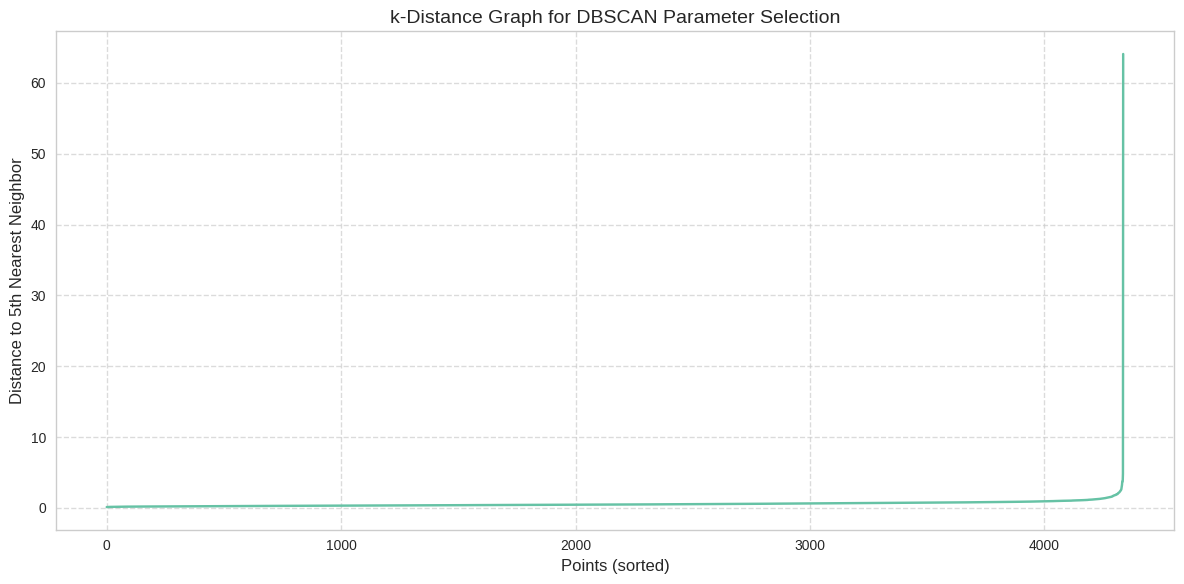

DBSCAN eps=0.5: 15 clusters, 1576 noise points (36.34%), silhouette=-0.0800
DBSCAN eps=0.75: 9 clusters, 456 noise points (10.51%), silhouette=-0.0187
DBSCAN eps=1.0: 1 clusters, 127 noise points (2.93%), silhouette=nan
DBSCAN eps=1.25: 1 clusters, 65 noise points (1.50%), silhouette=nan
DBSCAN eps=1.5: 1 clusters, 36 noise points (0.83%), silhouette=nan


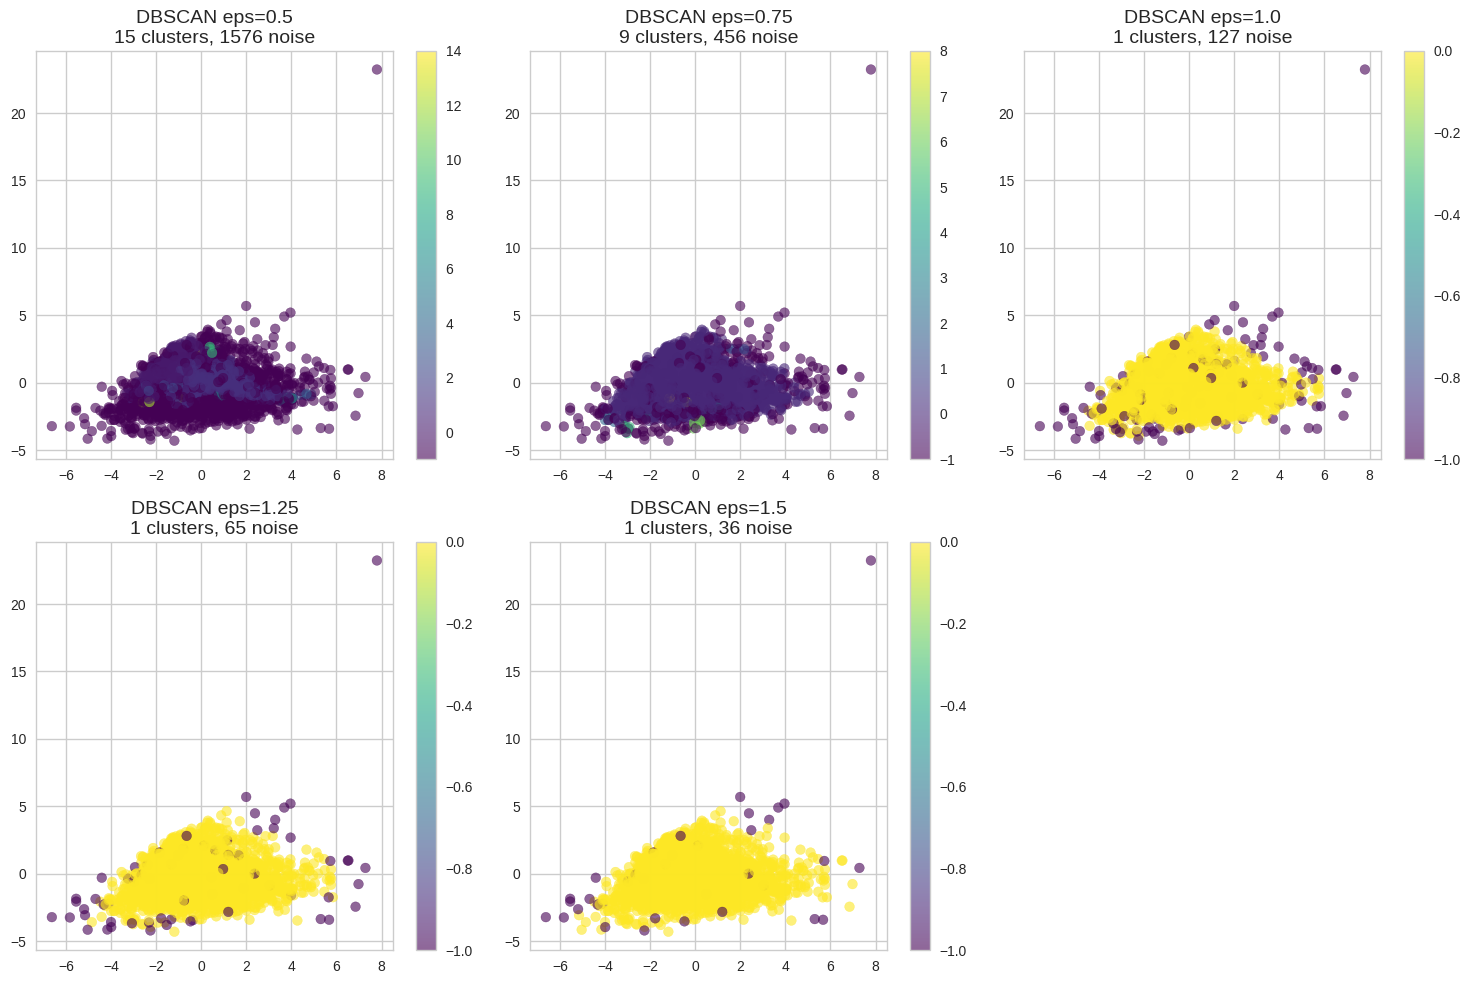


DBSCAN results for different eps values:
    eps  n_clusters  n_noise  noise_ratio  silhouette
0  0.50          15     1576     0.363385   -0.079957
1  0.75           9      456     0.105142   -0.018684
2  1.00           1      127     0.029283         NaN
3  1.25           1       65     0.014987         NaN
4  1.50           1       36     0.008301         NaN
Selected best eps value: 0.75
Final DBSCAN results: 9 clusters, 456 noise points (10.51%)


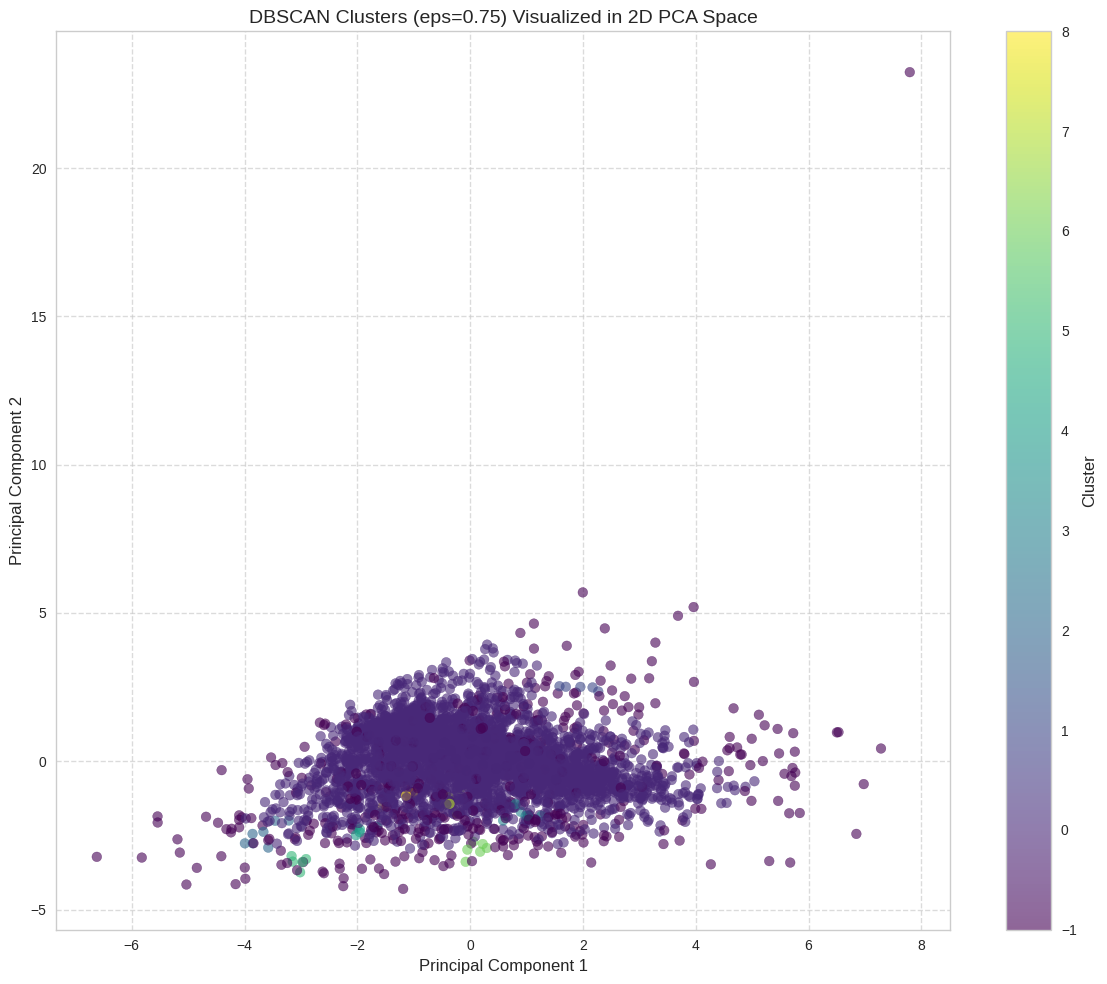

In [22]:
def apply_dbscan(X_scaled):
    """Apply DBSCAN clustering with optimal parameters."""
    from sklearn.neighbors import NearestNeighbors

    # Find optimal eps parameter using k-distance graph
    k = 5  # Choose an appropriate k
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_scaled)
    distances, indices = neigh.kneighbors(X_scaled)

    # Sort and plot distances to find the elbow
    distances = np.sort(distances[:, -1])

    plt.figure(figsize=(12, 6))
    plt.plot(distances)
    plt.xlabel('Points (sorted)')
    plt.ylabel(f'Distance to {k}th Nearest Neighbor')
    plt.title('k-Distance Graph for DBSCAN Parameter Selection')
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Choose eps values from the plot (look for an elbow point)
    # For this example, we'll try a range of values
    eps_values = [0.5, 0.75, 1.0, 1.25, 1.5]

    # Test various eps values
    results = []
    plt.figure(figsize=(15, 10))

    for i, eps in enumerate(eps_values):
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=5)
        dbscan_labels = dbscan.fit_predict(X_scaled)

        # Count number of clusters and noise points
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)

        # Calculate silhouette score (if possible)
        if n_clusters > 1 and len(dbscan_labels) - n_noise > 1:
            # We need at least 2 clusters and 2 non-noise points
            mask = dbscan_labels != -1
            if np.sum(mask) > 1:
                silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
            else:
                silhouette = float('nan')
        else:
            silhouette = float('nan')

        results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(dbscan_labels),
            'silhouette': silhouette
        })

        print(f"DBSCAN eps={eps}: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(dbscan_labels):.2%}), silhouette={silhouette:.4f}")

        # Plot clusters
        plt.subplot(2, 3, i+1)
        scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=dbscan_labels, cmap='viridis', alpha=0.6)
        plt.title(f'DBSCAN eps={eps}\n{n_clusters} clusters, {n_noise} noise')
        plt.colorbar(scatter)

    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame for better display
    results_df = pd.DataFrame(results)
    print("\nDBSCAN results for different eps values:")
    print(results_df)

    # Choose the best eps value based on a balance of number of clusters and noise ratio
    # For this example, we'll prioritize higher silhouette scores with reasonable noise levels
    valid_results = results_df[~results_df['silhouette'].isna() & (results_df['noise_ratio'] < 0.3)]

    if len(valid_results) > 0:
        best_eps_idx = valid_results['silhouette'].idxmax()
        best_eps = valid_results.loc[best_eps_idx, 'eps']
    else:
        # Default to a reasonable value if no valid options
        best_eps = 1.0
        print("No valid eps value found with good silhouette score and reasonable noise level.")

    print(f"Selected best eps value: {best_eps}")

    # Final DBSCAN with best parameters
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    # Count clusters and noise points
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    print(f"Final DBSCAN results: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(dbscan_labels):.2%})")

    return dbscan_labels, best_eps

# Apply DBSCAN clustering
dbscan_labels, best_eps = apply_dbscan(X_scaled_df.values)

# Visualize final DBSCAN clusters in PCA space
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'DBSCAN Clusters (eps={best_eps}) Visualized in 2D PCA Space')
plt.colorbar(scatter, label='Cluster')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Analyze Clusters


K-means Clustering Results:
Number of clusters: 5

Cluster Summary:
         Cluster Size  % of Customers  % of Revenue  Avg Recency (days)  \
Cluster                                                                   
0                 458           10.56          2.18               111.5   
1                1376           31.73         79.72                24.1   
2                 453           10.45          3.62                97.3   
3                   1            0.02          0.88               325.0   
4                2049           47.24         13.60               132.5   

         Avg Frequency  Avg Monetary  Avg Order Value  Product Diversity  
Cluster                                                                   
0                  2.1        415.88            12.99              0.373  
1                  9.3       5055.90            53.35              0.072  
2                  2.5        697.07            16.15              0.188  
3                  1.0      77

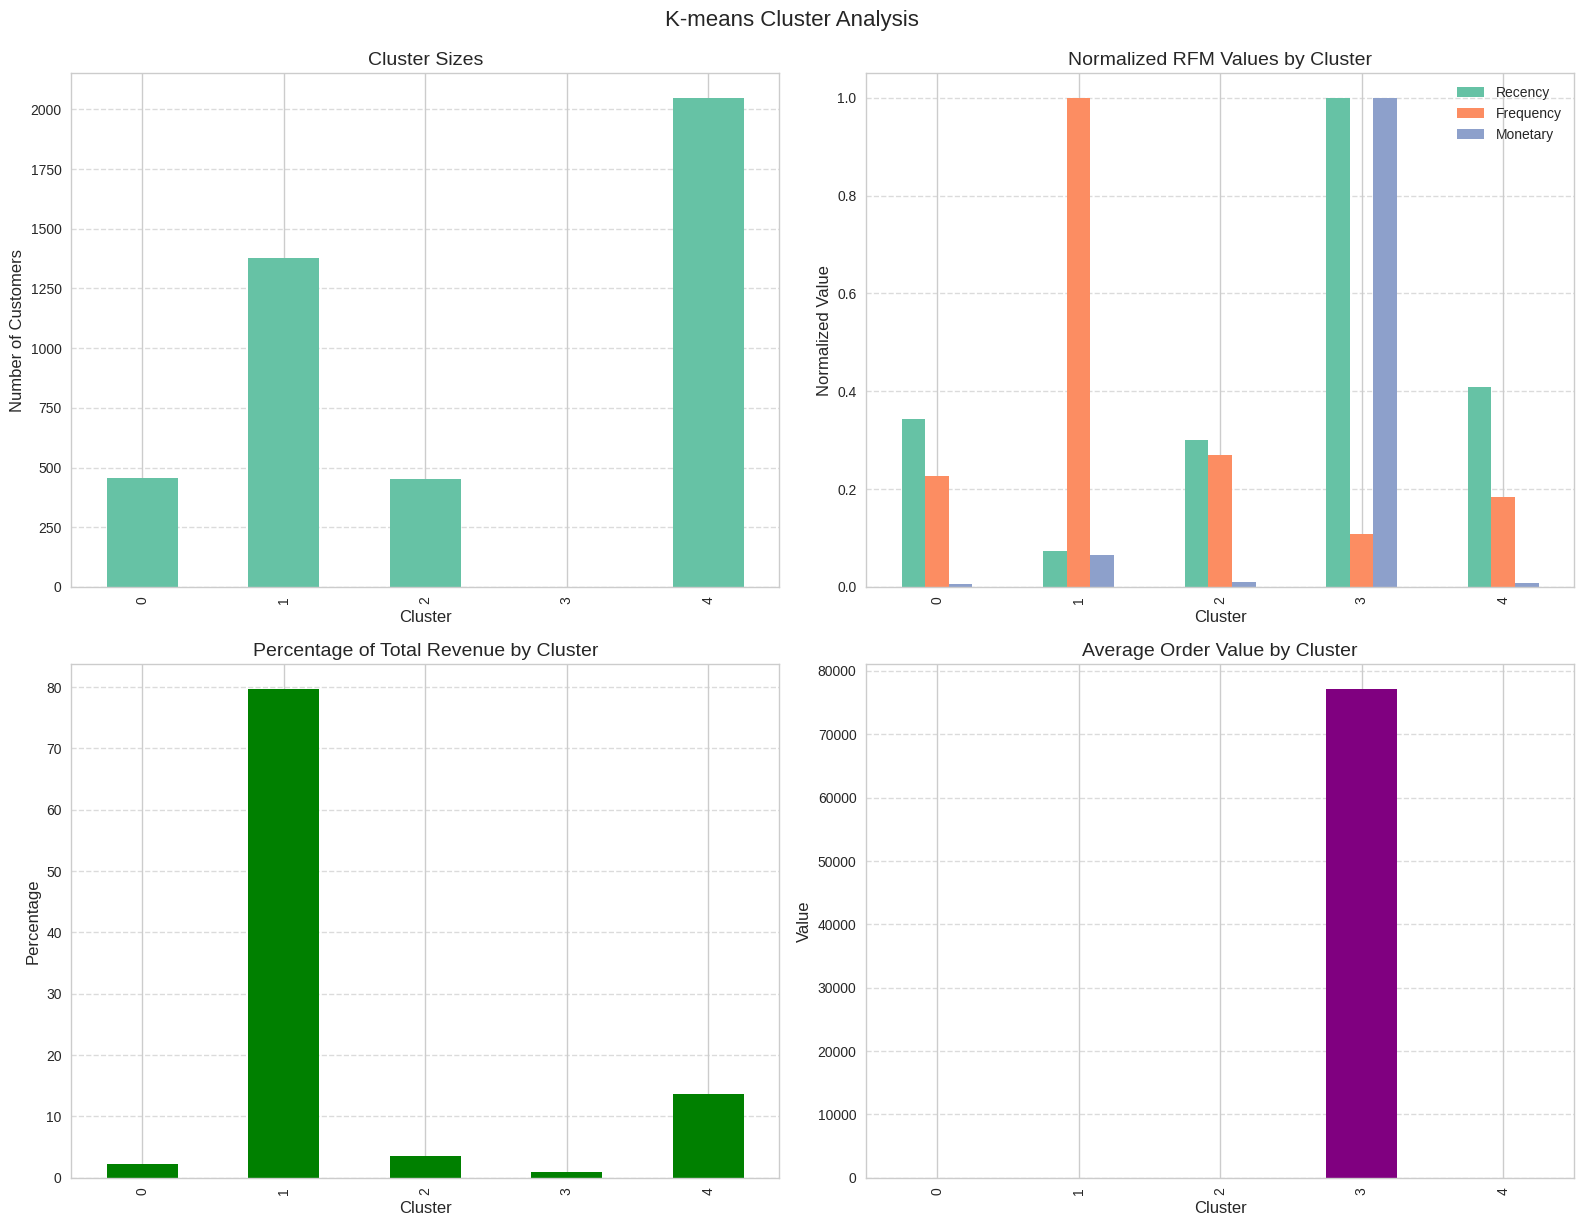


Hierarchical Clustering Results:
Number of clusters: 4

Cluster Summary:
         Cluster Size  % of Customers  % of Revenue  Avg Recency (days)  \
Cluster                                                                   
0                2206           50.86         13.67               134.0   
1                1540           35.51         79.87                31.3   
2                   1            0.02          0.88               325.0   
3                 590           13.60          5.58                95.1   

         Avg Frequency  Avg Monetary  Avg Order Value  Product Diversity  
Cluster                                                                   
0                  1.6        540.77            47.23              0.143  
1                  8.6       4526.13            30.90              0.080  
2                  1.0      77183.60         77183.60              0.000  
3                  2.8        824.89            19.25              0.177  


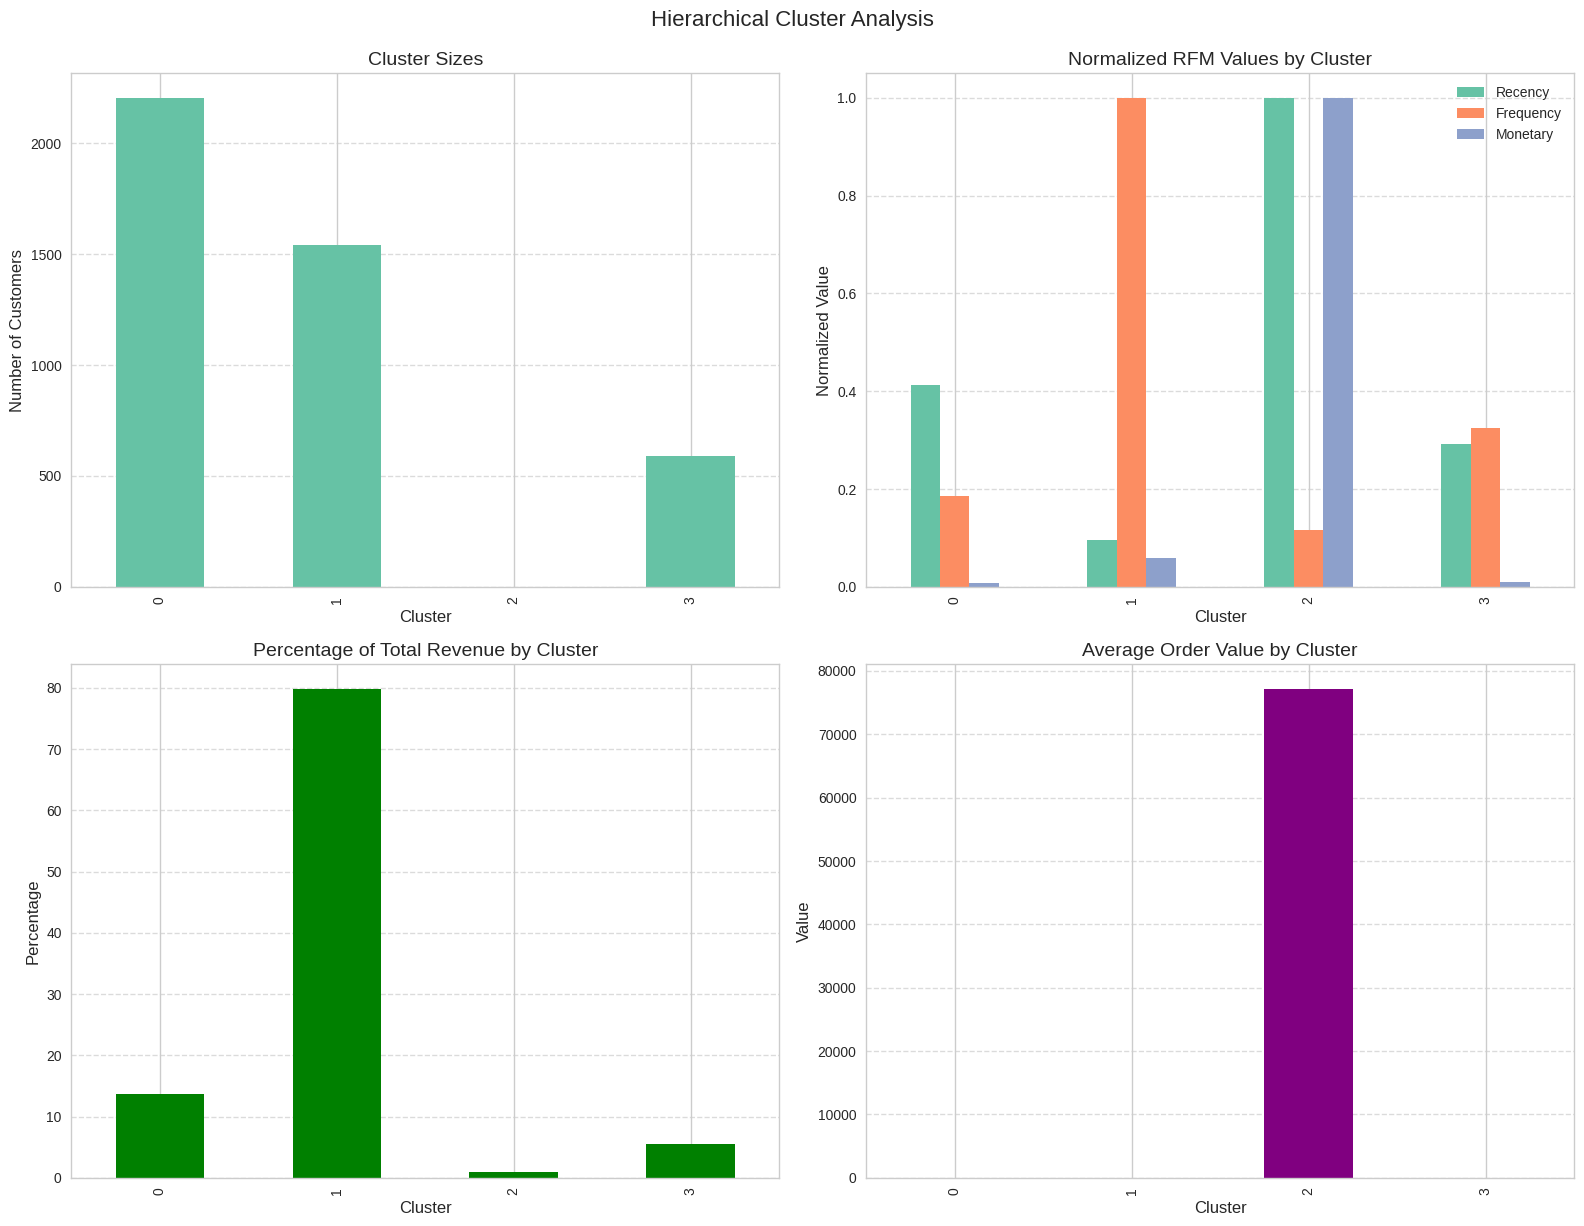


DBSCAN Clustering Results:
Number of clusters: 10
Noise points: 456 (10.51% of customers)
Number of actual clusters (excluding noise): 9

Cluster Summary:
         Cluster Size  % of Customers  % of Revenue  Avg Recency (days)  \
Cluster                                                                   
-1                456           10.51         39.21                75.2   
 0               3836           88.45         60.26                94.4   
 1                  5            0.12          0.14                93.8   
 2                  7            0.16          0.01               253.0   
 3                  7            0.16          0.17                30.4   
 4                  5            0.12          0.03                55.4   
 5                  5            0.12          0.01                38.6   
 6                  6            0.14          0.07                11.2   
 7                  5            0.12          0.06                87.6   
 8                 

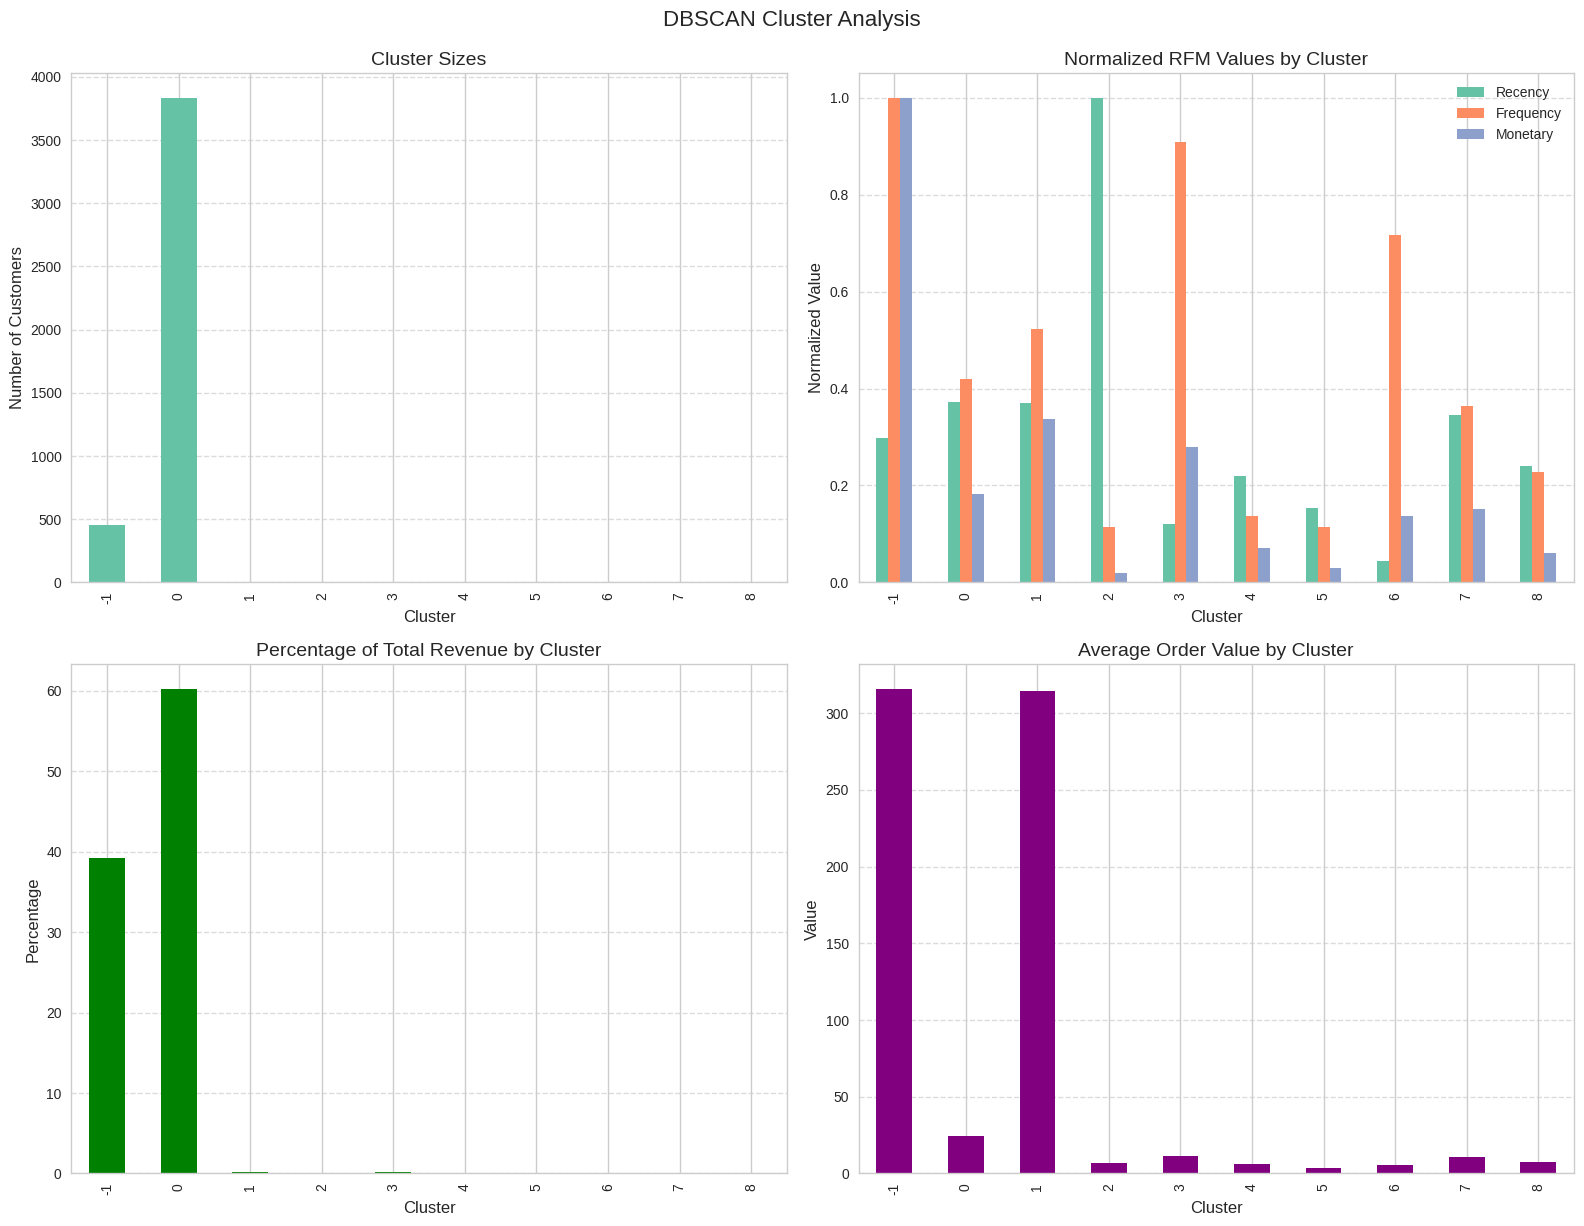

In [23]:
def analyze_clusters(customer_features, labels, cluster_method_name):
    """Analyze the clusters to understand their characteristics."""
    # Add cluster labels to the original customer features
    customer_clusters = customer_features.copy()
    customer_clusters = customer_clusters.reset_index()
    customer_clusters['Cluster'] = labels

    # Calculate key statistics for each cluster
    cluster_stats = customer_clusters.groupby('Cluster').agg({
        'Recency': ['mean', 'median'],
        'Frequency': ['mean', 'median'],
        'Monetary': ['mean', 'median', 'sum'],
        'TotalPrice_mean': ['mean', 'median'],
        'Quantity_mean': ['mean', 'median'],
        'ProductDiversity': ['mean', 'median'],
        'CustomerID': 'count'  # Count of customers in each cluster
    })

    # Flatten the column hierarchy
    cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]
    cluster_stats = cluster_stats.rename(columns={'CustomerID_count': 'Size'})

    # Calculate percentage of customers in each cluster
    cluster_stats['Size_Percentage'] = cluster_stats['Size'] / cluster_stats['Size'].sum() * 100

    # Calculate percentage of total monetary value by cluster
    total_monetary = customer_clusters['Monetary'].sum()
    cluster_stats['Monetary_Percentage'] = cluster_stats['Monetary_sum'] / total_monetary * 100

    # Print summary statistics
    print(f"\n{cluster_method_name} Clustering Results:")
    print(f"Number of clusters: {len(cluster_stats)}")
    if -1 in cluster_stats.index and cluster_method_name == 'DBSCAN':
        noise_size = cluster_stats.loc[-1, 'Size']
        noise_pct = cluster_stats.loc[-1, 'Size_Percentage']
        print(f"Noise points: {noise_size} ({noise_pct:.2f}% of customers)")
        print(f"Number of actual clusters (excluding noise): {len(cluster_stats)-1}")

    # Create a more readable summary table
    summary_table = pd.DataFrame({
        'Cluster Size': cluster_stats['Size'],
        '% of Customers': cluster_stats['Size_Percentage'].round(2),
        '% of Revenue': cluster_stats['Monetary_Percentage'].round(2),
        'Avg Recency (days)': cluster_stats['Recency_mean'].round(1),
        'Avg Frequency': cluster_stats['Frequency_mean'].round(1),
        'Avg Monetary': cluster_stats['Monetary_mean'].round(2),
        'Avg Order Value': cluster_stats['TotalPrice_mean_mean'].round(2),
        'Product Diversity': cluster_stats['ProductDiversity_mean'].round(3)
    })

    print("\nCluster Summary:")
    print(summary_table)

    # Visualize key characteristics by cluster
    plt.figure(figsize=(16, 12))

    # Plot 1: Cluster sizes
    plt.subplot(2, 2, 1)
    summary_table['Cluster Size'].plot(kind='bar', ax=plt.gca())
    plt.title('Cluster Sizes')
    plt.ylabel('Number of Customers')
    plt.xlabel('Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: RFM values by cluster
    plt.subplot(2, 2, 2)
    rfm_by_cluster = pd.DataFrame({
        'Recency': summary_table['Avg Recency (days)'],
        'Frequency': summary_table['Avg Frequency'],
        'Monetary': summary_table['Avg Monetary']
    })
    # Normalize for better visualization (values of different scales)
    rfm_by_cluster_scaled = rfm_by_cluster.div(rfm_by_cluster.max())
    rfm_by_cluster_scaled.plot(kind='bar', ax=plt.gca())
    plt.title('Normalized RFM Values by Cluster')
    plt.ylabel('Normalized Value')
    plt.xlabel('Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')

    # Plot 3: Revenue percentage by cluster
    plt.subplot(2, 2, 3)
    summary_table['% of Revenue'].plot(kind='bar', ax=plt.gca(), color='green')
    plt.title('Percentage of Total Revenue by Cluster')
    plt.ylabel('Percentage')
    plt.xlabel('Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 4: Average order value by cluster
    plt.subplot(2, 2, 4)
    summary_table['Avg Order Value'].plot(kind='bar', ax=plt.gca(), color='purple')
    plt.title('Average Order Value by Cluster')
    plt.ylabel('Value')
    plt.xlabel('Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.suptitle(f'{cluster_method_name} Cluster Analysis', fontsize=16, y=1.02)
    plt.show()

    return customer_clusters, summary_table

# Analyze K-means clusters
kmeans_customers, kmeans_summary = analyze_clusters(customer_features, kmeans_labels, 'K-means')

# Analyze hierarchical clusters
hc_customers, hc_summary = analyze_clusters(customer_features, hc_labels, 'Hierarchical')

# Analyze DBSCAN clusters
dbscan_customers, dbscan_summary = analyze_clusters(customer_features, dbscan_labels, 'DBSCAN')



## Profile and name clusters

In [24]:
def profile_and_name_clusters(summary_table, algorithm_name):
    """Profile and name the clusters based on their characteristics."""
    # Copy the summary table
    profile_df = summary_table.copy()

    # Add cluster names based on RFM characteristics
    cluster_names = {}

    # Get median values for comparison
    median_recency = profile_df['Avg Recency (days)'].median()
    median_frequency = profile_df['Avg Frequency'].median()
    median_monetary = profile_df['Avg Monetary'].median()

    for cluster in profile_df.index:
        # Skip noise points for DBSCAN
        if cluster == -1 and algorithm_name == 'DBSCAN':
            cluster_names[cluster] = "Noise (Outliers)"
            continue

        # Get cluster metrics
        recency = profile_df.loc[cluster, 'Avg Recency (days)']
        frequency = profile_df.loc[cluster, 'Avg Frequency']
        monetary = profile_df.loc[cluster, 'Avg Monetary']
        order_value = profile_df.loc[cluster, 'Avg Order Value']
        diversity = profile_df.loc[cluster, 'Product Diversity']

        # Profile the cluster
        is_recent = recency < median_recency
        is_frequent = frequency > median_frequency
        is_high_value = monetary > median_monetary

        # Determine name based on RFM profile
        if is_recent and is_frequent and is_high_value:
            name = "Champions"
        elif is_recent and is_frequent and not is_high_value:
            name = "Loyal Customers"
        elif is_recent and not is_frequent and is_high_value:
            name = "Big Spenders"
        elif is_recent and not is_frequent and not is_high_value:
            name = "New Customers"
        elif not is_recent and is_frequent and is_high_value:
            name = "At-Risk High-Value"
        elif not is_recent and is_frequent and not is_high_value:
            name = "At-Risk Regular"
        elif not is_recent and not is_frequent and is_high_value:
            name = "Former Big Spenders"
        elif not is_recent and not is_frequent and not is_high_value:
            name = "Lost Customers"
        else:
            name = f"Cluster {cluster}"

        # Add details about order value and product diversity
        if order_value > profile_df['Avg Order Value'].median():
            name += " (High Order Value)"
        if diversity > profile_df['Product Diversity'].median():
            name += " (Diverse Buyers)"
        elif diversity < profile_df['Product Diversity'].median() * 0.5:
            name += " (Focused Buyers)"

        cluster_names[cluster] = name

    # Add names to the profile dataframe
    profile_df['Segment Name'] = [cluster_names[c] for c in profile_df.index]

    # Display the named clusters
    print(f"\n{algorithm_name} Cluster Profiles:")
    for cluster, name in cluster_names.items():
        size = profile_df.loc[cluster, 'Cluster Size']
        pct = profile_df.loc[cluster, '% of Customers']
        revenue_pct = profile_df.loc[cluster, '% of Revenue']
        print(f"Cluster {cluster}: {name} - {size} customers ({pct:.2f}% of customers, {revenue_pct:.2f}% of revenue)")

    return profile_df, cluster_names

# Profile K-means clusters
kmeans_profiles, kmeans_names = profile_and_name_clusters(kmeans_summary, 'K-means')

# Profile hierarchical clusters
hc_profiles, hc_names = profile_and_name_clusters(hc_summary, 'Hierarchical')

# Profile DBSCAN clusters
dbscan_profiles, dbscan_names = profile_and_name_clusters(dbscan_summary, 'DBSCAN')


K-means Cluster Profiles:
Cluster 0: Lost Customers (Diverse Buyers) - 458 customers (10.56% of customers, 2.18% of revenue)
Cluster 1: Champions (High Order Value) - 1376 customers (31.73% of customers, 79.72% of revenue)
Cluster 2: Loyal Customers (Diverse Buyers) - 453 customers (10.45% of customers, 3.62% of revenue)
Cluster 3: Former Big Spenders (High Order Value) (Focused Buyers) - 1 customers (0.02% of customers, 0.88% of revenue)
Cluster 4: Lost Customers - 2049 customers (47.24% of customers, 13.60% of revenue)

Hierarchical Cluster Profiles:
Cluster 0: Lost Customers (High Order Value) (Diverse Buyers) - 2206 customers (50.86% of customers, 13.67% of revenue)
Cluster 1: Champions - 1540 customers (35.51% of customers, 79.87% of revenue)
Cluster 2: Former Big Spenders (High Order Value) (Focused Buyers) - 1 customers (0.02% of customers, 0.88% of revenue)
Cluster 3: Loyal Customers (Diverse Buyers) - 590 customers (13.60% of customers, 5.58% of revenue)

DBSCAN Cluster Profi

## Compare clustering methods


Clustering Algorithm Comparison:
      Algorithm  Number of Clusters  Silhouette Score  \
0       K-means                   5          0.305554   
1  Hierarchical                   4          0.273917   
2        DBSCAN                   9         -0.018684   

   Calinski-Harabasz Score  Noise Points  
0              1458.363373             0  
1              1259.014822             0  
2                19.556124           456  

Based on silhouette score, the best clustering algorithm is: K-means


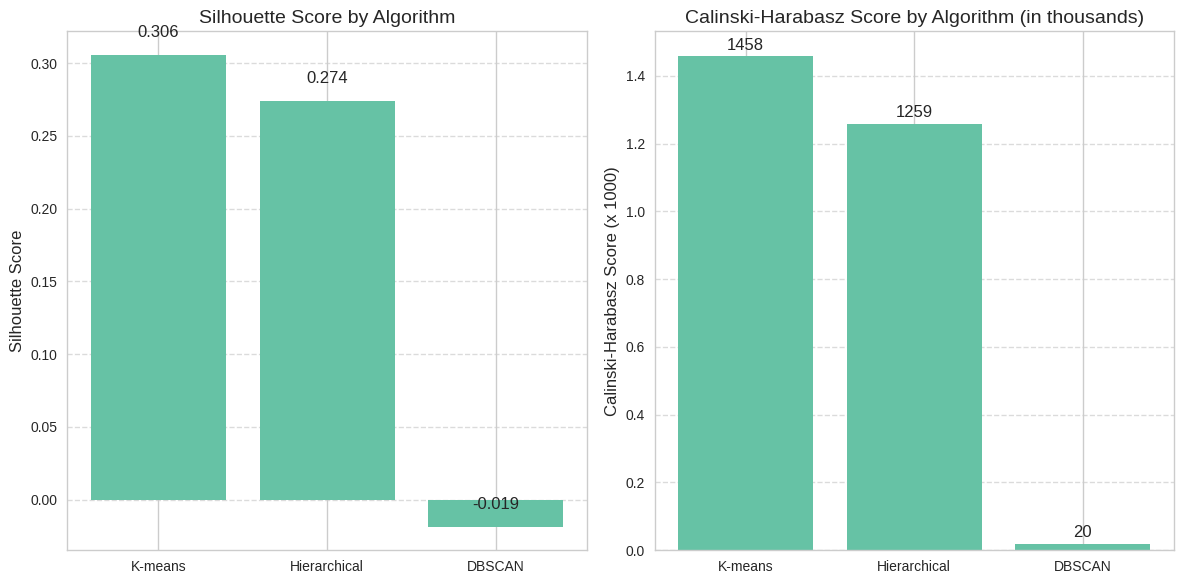

In [25]:
def compare_clustering_methods(X_scaled, kmeans_labels, hc_labels, dbscan_labels):
    """Compare the performance of different clustering algorithms."""
    # Calculate silhouette scores
    kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
    hc_silhouette = silhouette_score(X_scaled, hc_labels)

    # For DBSCAN, exclude noise points (-1) when calculating silhouette score
    dbscan_mask = dbscan_labels != -1
    if np.sum(dbscan_mask) > 1:  # Need at least 2 non-noise points
        dbscan_silhouette = silhouette_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask])
    else:
        dbscan_silhouette = float('nan')

    # Calculate Calinski-Harabasz scores
    kmeans_ch = calinski_harabasz_score(X_scaled, kmeans_labels)
    hc_ch = calinski_harabasz_score(X_scaled, hc_labels)
    if np.sum(dbscan_mask) > 1:
        dbscan_ch = calinski_harabasz_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask])
    else:
        dbscan_ch = float('nan')

    # Count unique clusters (excluding noise for DBSCAN)
    kmeans_clusters = len(np.unique(kmeans_labels))
    hc_clusters = len(np.unique(hc_labels))
    dbscan_clusters = len(np.unique(dbscan_labels[dbscan_labels != -1]))
    dbscan_noise = np.sum(dbscan_labels == -1)

    # Create comparison table
    comparison = pd.DataFrame({
        'Algorithm': ['K-means', 'Hierarchical', 'DBSCAN'],
        'Number of Clusters': [kmeans_clusters, hc_clusters, dbscan_clusters],
        'Silhouette Score': [kmeans_silhouette, hc_silhouette, dbscan_silhouette],
        'Calinski-Harabasz Score': [kmeans_ch, hc_ch, dbscan_ch],
        'Noise Points': [0, 0, dbscan_noise]
    })

    print("\nClustering Algorithm Comparison:")
    print(comparison)

    # Determine best algorithm based on silhouette score
    valid_comparison = comparison[~comparison['Silhouette Score'].isna()]
    if not valid_comparison.empty:
        best_silhouette_idx = valid_comparison['Silhouette Score'].idxmax()
        best_algorithm = valid_comparison.loc[best_silhouette_idx, 'Algorithm']
        print(f"\nBased on silhouette score, the best clustering algorithm is: {best_algorithm}")
    else:
        best_algorithm = "K-means"  # Default if we can't determine
        print("\nCould not determine best algorithm based on silhouette score. Using K-means as default.")

    # Visualize comparison of validation metrics
    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(1, 2, 1)
    bars1 = ax1.bar(comparison['Algorithm'], comparison['Silhouette Score'])
    ax1.set_title('Silhouette Score by Algorithm')
    ax1.set_ylabel('Silhouette Score')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if not np.isnan(height):
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')

    ax2 = plt.subplot(1, 2, 2)
    bars2 = ax2.bar(comparison['Algorithm'], comparison['Calinski-Harabasz Score'] / 1000)  # Scale down for readability
    ax2.set_title('Calinski-Harabasz Score by Algorithm (in thousands)')
    ax2.set_ylabel('Calinski-Harabasz Score (x 1000)')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        if not np.isnan(height):
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height*1000:.0f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return best_algorithm, comparison

# Compare clustering methods
best_algorithm, comparison_df = compare_clustering_methods(
    X_scaled_df.values, kmeans_labels, hc_labels, dbscan_labels
)

## Final customer segmentation

Creating final customer segmentation using K-means...

Final Customer Segment Distribution:
                                                    Count  Percentage
Segment_Name                                                         
Lost Customers                                       2049   47.244639
Champions (High Order Value)                         1376   31.727000
Lost Customers (Diverse Buyers)                       458   10.560295
Loyal Customers (Diverse Buyers)                      453   10.445008
Former Big Spenders (High Order Value) (Focused...      1    0.023057


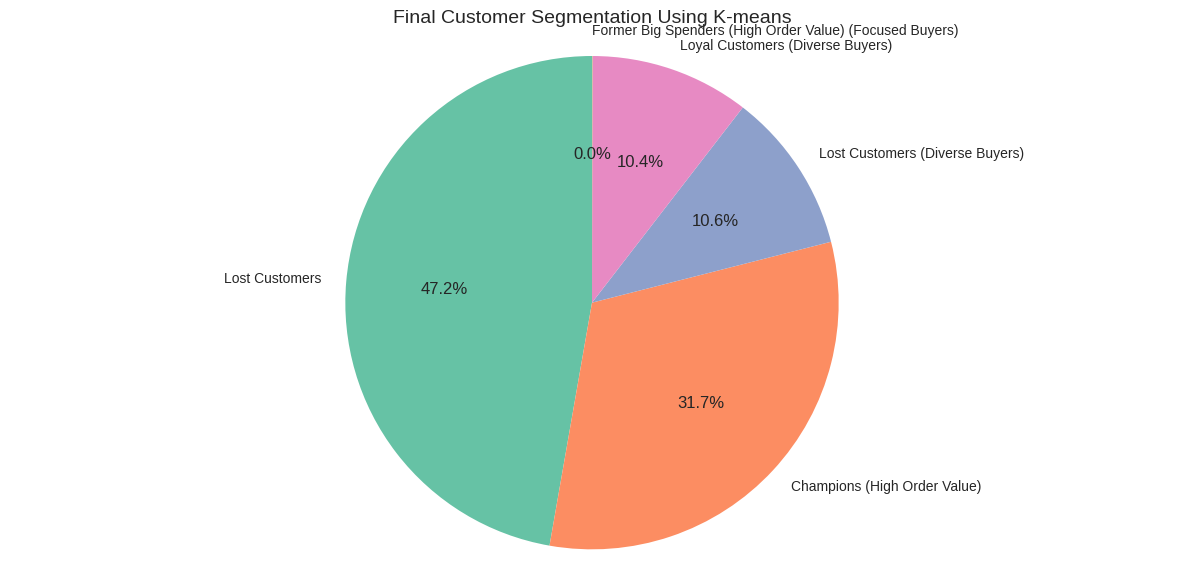

In [26]:
def create_final_segmentation(customer_features, best_algorithm,
                             kmeans_labels, kmeans_names,
                             hc_labels, hc_names,
                             dbscan_labels, dbscan_names):
    """Create the final customer segmentation based on the best algorithm."""
    print(f"Creating final customer segmentation using {best_algorithm}...")

    # Choose the best clustering labels and names based on the best algorithm
    if best_algorithm == 'K-means':
        final_labels = kmeans_labels
        cluster_names = kmeans_names
    elif best_algorithm == 'Hierarchical':
        final_labels = hc_labels
        cluster_names = hc_names
    else:  # DBSCAN
        final_labels = dbscan_labels
        cluster_names = dbscan_names

    # Create final segmentation dataframe
    final_segmentation = customer_features.copy().reset_index()
    final_segmentation['Segment'] = final_labels
    final_segmentation['Segment_Name'] = final_segmentation['Segment'].map(cluster_names)

    # Print segment distribution
    print("\nFinal Customer Segment Distribution:")
    segment_counts = final_segmentation['Segment_Name'].value_counts()
    segment_percentages = final_segmentation['Segment_Name'].value_counts(normalize=True) * 100

    segment_distribution = pd.DataFrame({
        'Count': segment_counts,
        'Percentage': segment_percentages
    })
    print(segment_distribution)

    # Visualize final segments
    plt.figure(figsize=(12, 6))
    plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Final Customer Segmentation Using {best_algorithm}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.tight_layout()
    plt.show()

    return final_segmentation

# Create final customer segmentation
final_segmentation = create_final_segmentation(
    customer_features, best_algorithm,
    kmeans_labels, kmeans_names,
    hc_labels, hc_names,
    dbscan_labels, dbscan_names
)

## Generate business recommendations

In [27]:
def generate_recommendations(final_segmentation):
    """Generate business recommendations for each customer segment."""
    # Get unique segment names
    segments = final_segmentation['Segment_Name'].unique()

    print("\nBusiness Recommendations for Customer Segments:")

    for segment in segments:
        # Skip noise segment if present
        if segment == "Noise (Outliers)":
            print(f"\n{segment}:")
            print("- Investigate these customers individually to understand their unusual behavior")
            print("- They may represent special cases or data quality issues")
            continue

        segment_data = final_segmentation[final_segmentation['Segment_Name'] == segment]
        segment_size = len(segment_data)
        segment_percent = (segment_size / len(final_segmentation)) * 100
        avg_monetary = segment_data['Monetary'].mean()
        avg_recency = segment_data['Recency'].mean()
        avg_frequency = segment_data['Frequency'].mean()

        print(f"\n{segment}:")
        print(f"Size: {segment_size} customers ({segment_percent:.2f}%)")
        print(f"Average Total Spending: £{avg_monetary:.2f}")
        print(f"Average Recency: {avg_recency:.1f} days")
        print(f"Average Purchase Frequency: {avg_frequency:.1f} orders")
        print("Recommendations:")

        # Generate specific recommendations based on segment name
        if "Champions" in segment:
            print("- Create a VIP program with exclusive benefits and early access to new products")
            print("- Implement loyalty rewards and personalized offers")
            print("- Collect feedback from these customers on product development")
            print("- Send personalized thank-you notes with each order")

        elif "Loyal" in segment:
            print("- Develop a tiered loyalty program to reward repeat purchases")
            print("- Offer special promotions and cross-sell opportunities")
            print("- Create bundle deals of frequently purchased items")
            print("- Send personalized product recommendations based on purchase history")

        elif "Big Spenders" in segment:
            print("- Send personalized offers to increase purchase frequency")
            print("- Focus on premium product offerings")
            print("- Provide white-glove customer service")
            print("- Create volume-based discount programs")

        elif "New Customers" in segment:
            print("- Create welcome series emails with product education")
            print("- Send first-time buyer follow-up with satisfaction survey")
            print("- Offer incentives for second purchase to drive repeat business")
            print("- Highlight best-selling products for new customers")

        elif "At-Risk" in segment:
            print("- Implement re-engagement campaign with special offers")
            print("- Request feedback on previous purchases")
            print("- Send 'we miss you' emails with personalized discounts")
            print("- Introduce new product lines that may interest them")

        elif "Former" in segment:
            print("- Launch win-back campaign with significant incentives")
            print("- Highlight new products and improvements since their last purchase")
            print("- Survey to understand why they stopped purchasing")
            print("- Consider special pricing for returning customers")

        elif "Lost" in segment:
            print("- Send final attempt re-activation campaign with deep discounts")
            print("- Offer a special 'welcome back' promotion")
            print("- Consider removing from regular email communication if no response")
            print("- Analyze reasons for customer loss to improve retention")

        # Add recommendations based on buying behavior
        if "High Order Value" in segment:
            print("- Focus on premium offerings and bundle deals")
            print("- Introduce tiered pricing with benefits at higher tiers")

        if "Diverse Buyers" in segment:
            print("- Highlight product variety and new arrivals")
            print("- Create curated collections from different product categories")

        if "Focused Buyers" in segment:
            print("- Suggest complementary products to expand their purchases")
            print("- Create educational content about other product categories")

    # Overall recommendations
    print("\nOverall Recommendations:")
    print("1. Implement a comprehensive CRM system to track customer behavior and segment-specific interactions")
    print("2. Develop personalized marketing campaigns for each customer segment")
    print("3. Set up automated email flows based on customer segment and behavior")
    print("4. Regularly update segmentation as customer behavior changes")
    print("5. Track key performance metrics by segment to measure the effectiveness of targeted strategies")

# Generate business recommendations
generate_recommendations(final_segmentation)


Business Recommendations for Customer Segments:

Former Big Spenders (High Order Value) (Focused Buyers):
Size: 1 customers (0.02%)
Average Total Spending: £77183.60
Average Recency: 325.0 days
Average Purchase Frequency: 1.0 orders
Recommendations:
- Send personalized offers to increase purchase frequency
- Focus on premium product offerings
- Provide white-glove customer service
- Create volume-based discount programs
- Focus on premium offerings and bundle deals
- Introduce tiered pricing with benefits at higher tiers
- Suggest complementary products to expand their purchases
- Create educational content about other product categories

Champions (High Order Value):
Size: 1376 customers (31.73%)
Average Total Spending: £5055.90
Average Recency: 24.1 days
Average Purchase Frequency: 9.3 orders
Recommendations:
- Create a VIP program with exclusive benefits and early access to new products
- Implement loyalty rewards and personalized offers
- Collect feedback from these customers on p